In [1]:
import logging
import os
import time
import requests
logging.basicConfig(format='[%(asctime)s] (%(levelname)s): %(message)s', level=logging.INFO)

# Installed libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt
%matplotlib inline
# Imports from our package
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

[2021-05-17 19:10:41,677] (WARNING): /Users/shinkovskiymichael/anaconda3/envs/ml/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)



In [13]:
N_THREADS = 8 # threads cnt for lgbm and linear models
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 3600 # Time in seconds for automl run
TARGET_NAME = 'final_price' # Target column name

In [14]:
s1 = [('mean', np.mean), ('min', np.nanmin), ('max', np.nanmax)]
s2 = [('mean', np.mean), ('min', np.nanmin), ('max', np.nanmax), ('median', np.median)]
s = [s2]

In [15]:
g1 = {'use_algos': ['linear_l2', 'lgb', 'lgb_tuned']}
g2 = {'use_algos':'auto'}
g3 = {'use_algos': ['lgb', 'lgb_tuned', 'linear_l2', 'cb', 'cb_tuned']}
g4 = {'use_algos': [['lgb', 'lgb_tuned', 'linear_l2', 'cb', 'cb_tuned'], ['lgb', 'linear_l2']]}
g = [g1, g3, g4]

In [16]:
freqs = [5, 10, 15]

In [17]:
train_data = pd.read_csv('train_data.csv')

In [18]:
corrupted_prices = [1111111.0, 8388607.0, 111111.0, 6666666.0]

In [19]:
train_data = train_data[~train_data[TARGET_NAME].isin(corrupted_prices)]

In [20]:
# def make_prediction(general_params, statistics, freq):
#     train_data = pd.read_csv('train_data.csv')
#     # train_data = train_data[train_data[TARGET_NAME]>1000][~train_data[TARGET_NAME].isin(corrupted_prices)]
#     test_data = pd.read_csv('test_data.csv')
#     submission = pd.read_csv('sample_submission.csv')

#     def create_extra_features(data):
#         data['NANs_cnt'] = data.isnull().sum(axis = 1) 
        
#     def create_col_with_min_freq(data, col, min_freq = 10):
#         # replace rare values (less than min_freq rows) in feature by RARE_VALUE
#         data[col + '_fixed'] = data[col].astype(str)
#         data.loc[data[col + '_fixed'].value_counts()[data[col + '_fixed']].values < min_freq, col + '_fixed'] = "RARE_VALUE"
#         data.replace({'nan': np.nan}, inplace = True)

#     def create_gr_feats(data):
#         # create aggregation feats for numeric features based on categorical ones
#         for cat_col in ['vehicle_manufacturer', 'vehicle_model', 'vehicle_category',
#                     'vehicle_gearbox_type', 'doors_cnt', 'wheels', 'vehicle_color', 
#                     'vehicle_interior_color', 'deal_type']:
#             create_col_with_min_freq(data, cat_col, freq)
#             for num_col in ['current_mileage', 'vehicle_year', 'car_leather_interior']:
#                 for n, f in statistics:
#                     data['FIXED_' + n + '_' + num_col + '_by_' + cat_col] = data.groupby(cat_col + '_fixed')[num_col].transform(f)
                    
#         # create features with counts
#         for col in ['vehicle_manufacturer', 'vehicle_model', 'vehicle_category',
#                 'current_mileage', 'vehicle_year', 'vehicle_gearbox_type', 'doors_cnt',
#                 'wheels', 'vehicle_color', 'vehicle_interior_color', 'car_vin', 'deal_type']:
#             data[col + '_cnt'] = data[col].map(data[col].value_counts(dropna = False))
        
            

#     create_extra_features(train_data)
#     create_extra_features(test_data)

#     all_df = pd.concat([train_data, test_data]).reset_index(drop = True)
#     create_gr_feats(all_df)
#     train_data, test_data = all_df[:len(train_data)], all_df[len(train_data):]
#     print(train_data.shape, test_data.shape)

#     train_data, val_data = train_test_split(train_data, test_size = 0.2, random_state = RANDOM_STATE)
#     print(train_data.shape, val_data.shape)
#     task = Task('reg', loss='mae', metric='mae')
#     automl = TabularUtilizedAutoML(task = task, verbose=0,
#                        timeout = TIMEOUT,
#                        cpu_limit = N_THREADS,
#                        general_params = general_params,
#                        reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
#                       )

#     roles = {'target': TARGET_NAME,
#          'drop': ['row_ID'] # to drop or not to drop?
#          }
#     oof_pred = automl.fit_predict(train_data, roles = roles)
#     logging.info('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

#     val_pred = automl.predict(val_data)
#     logging.info('Prediction for val data:\n{}\nShape = {}'.format(val_pred, val_data.shape))

#     logging.info('Check scores...')
#     val_mae = mean_absolute_error(val_data[TARGET_NAME].values, val_pred.data[:, 0])
#     logging.info('MAE score for val_data: {}'.format(val_mae))
#     return val_mae, val_data, automl

In [21]:
def make_final_prediction(general_params, statistics, freq):
    train_data = pd.read_csv('train_data.csv')
    train_data = train_data[~train_data[TARGET_NAME].isin(corrupted_prices)]
    test_data = pd.read_csv('test_data.csv')
    submission = pd.read_csv('sample_submission.csv')

    def create_extra_features(data):
        data['NANs_cnt'] = data.isnull().sum(axis = 1) 
        
    def create_col_with_min_freq(data, col, min_freq = 10):
        # replace rare values (less than min_freq rows) in feature by RARE_VALUE
        data[col + '_fixed'] = data[col].astype(str)
        data.loc[data[col + '_fixed'].value_counts()[data[col + '_fixed']].values < min_freq, col + '_fixed'] = "RARE_VALUE"
        data.replace({'nan': np.nan}, inplace = True)

    def create_gr_feats(data):
        # create aggregation feats for numeric features based on categorical ones
        for cat_col in ['vehicle_manufacturer', 'vehicle_model', 'vehicle_category',
                    'vehicle_gearbox_type', 'doors_cnt', 'wheels', 'vehicle_color', 
                    'vehicle_interior_color', 'deal_type']:
            create_col_with_min_freq(data, cat_col, freq)
            for num_col in ['current_mileage', 'vehicle_year', 'car_leather_interior']:
                for n, f in statistics:
                    data['FIXED_' + n + '_' + num_col + '_by_' + cat_col] = data.groupby(cat_col + '_fixed')[num_col].transform(f)
                    
        # create features with counts
        for col in ['vehicle_manufacturer', 'vehicle_model', 'vehicle_category',
                'current_mileage', 'vehicle_year', 'vehicle_gearbox_type', 'doors_cnt',
                'wheels', 'vehicle_color', 'vehicle_interior_color', 'car_vin', 'deal_type']:
            data[col + '_cnt'] = data[col].map(data[col].value_counts(dropna = False))
        
            

    create_extra_features(train_data)
    create_extra_features(test_data)

    all_df = pd.concat([train_data, test_data]).reset_index(drop = True)
    create_gr_feats(all_df)
    train_data, test_data = all_df[:len(train_data)], all_df[len(train_data):]
    print(train_data.shape, test_data.shape)

    task = Task('reg', loss='mae', metric='mae')
    automl = TabularUtilizedAutoML(
        task = task,
        timeout = TIMEOUT,
        cpu_limit = N_THREADS,
        general_params = {'use_algos': [['linear_l2', 'lgb', 'lgb_tuned']]},
        # general_params = general_params,
        reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
    )

    roles = {'target': TARGET_NAME,
         'drop': ['row_ID'] # to drop or not to drop?
         }
    oof_pred = automl.fit_predict(train_data, roles = roles)
    logging.info('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

    test_pred = automl.predict(test_data)
    return test_pred, automl

In [22]:
# ls = []
# for g_i in g:
#     for s_i in s:
#         start = time.time()
#         val_mae, _, _ = make_prediction(g_i, s_i, 15)
#         end = time.time()
#         elapsed = end - start
#         print(f'Training took: {elapsed} secods')
#         ls.append((val_mae, str(g_i), str(s_i)))


In [23]:
test_pred, auto_ml = make_final_prediction(g1, s2, 15)

sklearn doesn't support in general case mae and will not be used.


(34994, 145) (10697, 145)
Current random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
Found reader_params in kwargs, need to combine
Merged variant for reader_params = {'n_jobs': 8, 'cv': 5, 'random_state': 42}
Found general_params in kwargs, need to combine
Merged variant for general_params = {'use_algos': [['linear_l2', 'lgb', 'lgb_tuned']], 'return_all_predictions': False}
Start automl preset with listed constraints:
- time: 3599.9972202777863 seconds
- cpus: 8 cores
- memory: 16 gb

Train data shape: (34994, 145)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 3592.852639436722 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = -3625.3401783053273
Linear model: C = 5e-05 score = -3617.9109012294725
Linear model: C = 0.0001 score = -3608.362453041562
Linear model: C = 0.0005 sco

Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[2021-05-17 19:12:53,110] (INFO): A new study created in memory with name: no-name-984f206d-2efc-4325-87cd-1057045a70d7


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1616.83
[200]	valid's l1: 1504.84
[300]	valid's l1: 1484.81
[400]	valid's l1: 1471.29
[500]	valid's l1: 1465.03
[600]	valid's l1: 1463.02
[700]	valid's l1: 1456.03
[800]	valid's l1: 1453.13
[900]	valid's l1: 1449.7
[1000]	valid's l1: 1447.63
[1100]	valid's l1: 1444.97
[1200]	valid's l1: 1442.95
Did not meet early stopping. Best iteration is:
[1187]	valid's l1: 1442.84
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:13:00,785] (INFO): Trial 0 finished with value: -1442.8358796018756 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 108, 'bagging_fraction': 0.5917173949330818, 'min_sum_hessian_in_leaf': 1.3145103232150122, 'reg_alpha': 0.0023531598052637494, 'reg_lambda': 0.00010291881465670109}. Best is trial 0 with value: -1442.8358796018756.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1567.08
[200]	valid's l1: 1451.47
[300]	valid's l1: 1438.36
[400]	valid's l1: 1429.81
[500]	valid's l1: 1425.1
[600]	valid's l1: 1423.7
[700]	valid's l1: 1423.14
[800]	valid's l1: 1422.2
[900]	valid's l1: 1420.29
[1000]	valid's l1: 1418.46
[1100]	valid's l1: 1416.8
[1200]	valid's l1: 1415.35
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1415.35
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:13:12,510] (INFO): Trial 1 finished with value: -1415.3474591795862 and parameters: {'feature_fraction': 0.5499874579090014, 'num_leaves': 218, 'bagging_fraction': 0.9330880728874675, 'min_sum_hessian_in_leaf': 0.2537815508265665, 'reg_alpha': 0.023585940584142682, 'reg_lambda': 1.5320059381854043e-08}. Best is trial 1 with value: -1415.3474591795862.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1578.03
[200]	valid's l1: 1450.79
[300]	valid's l1: 1431.3
[400]	valid's l1: 1421.62
[500]	valid's l1: 1417.35
[600]	valid's l1: 1413.13
[700]	valid's l1: 1410.15
[800]	valid's l1: 1408.17
[900]	valid's l1: 1406.47
[1000]	valid's l1: 1403.34
[1100]	valid's l1: 1401.72
[1200]	valid's l1: 1400.49
Did not meet early stopping. Best iteration is:
[1189]	valid's l1: 1400.35
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:13:29,420] (INFO): Trial 2 finished with value: -1400.3482893991 and parameters: {'feature_fraction': 0.9849549260809971, 'num_leaves': 251, 'bagging_fraction': 0.9692763545078751, 'min_sum_hessian_in_leaf': 0.0010071984838809194, 'reg_alpha': 8.509499823666633, 'reg_lambda': 0.0036085571407386235}. Best is trial 2 with value: -1400.3482893991.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1578.51
[200]	valid's l1: 1474.03
[300]	valid's l1: 1455.02
[400]	valid's l1: 1450.06
[500]	valid's l1: 1444.25
[600]	valid's l1: 1444.39
[700]	valid's l1: 1441.58
[800]	valid's l1: 1437.74
[900]	valid's l1: 1435.62
[1000]	valid's l1: 1433.04
[1100]	valid's l1: 1430.98
[1200]	valid's l1: 1428.4
Did not meet early stopping. Best iteration is:
[1195]	valid's l1: 1428.38
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:13:44,074] (INFO): Trial 3 finished with value: -1428.3835778625407 and parameters: {'feature_fraction': 0.8058265802441404, 'num_leaves': 251, 'bagging_fraction': 0.5115312125207079, 'min_sum_hessian_in_leaf': 0.12563152773938666, 'reg_alpha': 3.9696182670988566e-05, 'reg_lambda': 2.630213296503227e-08}. Best is trial 2 with value: -1400.3482893991.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1755.93
[200]	valid's l1: 1645.51
[300]	valid's l1: 1618.21
[400]	valid's l1: 1601.2
[500]	valid's l1: 1595.64
[600]	valid's l1: 1589.57
[700]	valid's l1: 1579.8
[800]	valid's l1: 1572.78
[900]	valid's l1: 1566.98
[1000]	valid's l1: 1563.73
[1100]	valid's l1: 1562.15
[1200]	valid's l1: 1559.7
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1559.7
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:13:48,432] (INFO): Trial 4 finished with value: -1559.7048759295064 and parameters: {'feature_fraction': 0.9868777594207296, 'num_leaves': 30, 'bagging_fraction': 0.728034992108518, 'min_sum_hessian_in_leaf': 1.382623217936987, 'reg_alpha': 6.267062696005991e-07, 'reg_lambda': 0.00042472707398058225}. Best is trial 2 with value: -1400.3482893991.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1591.22
[200]	valid's l1: 1477.52
[300]	valid's l1: 1468.77
[400]	valid's l1: 1461.64
[500]	valid's l1: 1458.45
[600]	valid's l1: 1456.43
[700]	valid's l1: 1454.62
[800]	valid's l1: 1454.38
[900]	valid's l1: 1453.84
[1000]	valid's l1: 1453.93
[1100]	valid's l1: 1452.49
[1200]	valid's l1: 1450.88
Did not meet early stopping. Best iteration is:
[1199]	valid's l1: 1450.87
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:13:58,388] (INFO): Trial 5 finished with value: -1450.8670836608228 and parameters: {'feature_fraction': 0.7962072844310213, 'num_leaves': 146, 'bagging_fraction': 0.9299702033681603, 'min_sum_hessian_in_leaf': 0.5262961031076743, 'reg_alpha': 0.00011336872639641431, 'reg_lambda': 1.316390230170444e-08}. Best is trial 2 with value: -1400.3482893991.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1740.42
[200]	valid's l1: 1634.11
[300]	valid's l1: 1612.85
[400]	valid's l1: 1598.37
[500]	valid's l1: 1593.55
[600]	valid's l1: 1587.62
[700]	valid's l1: 1585.89
[800]	valid's l1: 1582.86
[900]	valid's l1: 1579.12
[1000]	valid's l1: 1577.11
[1100]	valid's l1: 1576.5
[1200]	valid's l1: 1574.35
Did not meet early stopping. Best iteration is:
[1197]	valid's l1: 1574.34
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:14:02,884] (INFO): Trial 6 finished with value: -1574.3428960502922 and parameters: {'feature_fraction': 0.9711008778424264, 'num_leaves': 29, 'bagging_fraction': 0.9041986740582306, 'min_sum_hessian_in_leaf': 0.01653693718282442, 'reg_alpha': 7.569183361880229e-08, 'reg_lambda': 0.014391207615728067}. Best is trial 2 with value: -1400.3482893991.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1582.25
[200]	valid's l1: 1467.62
[300]	valid's l1: 1451.13
[400]	valid's l1: 1445.69
[500]	valid's l1: 1438.39
[600]	valid's l1: 1432.32
[700]	valid's l1: 1429.38
[800]	valid's l1: 1425.53
[900]	valid's l1: 1424.06
[1000]	valid's l1: 1421.97
[1100]	valid's l1: 1420.83
[1200]	valid's l1: 1419.14
Did not meet early stopping. Best iteration is:
[1193]	valid's l1: 1419.06
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:14:15,062] (INFO): Trial 7 finished with value: -1419.062143462141 and parameters: {'feature_fraction': 0.7200762468698007, 'num_leaves': 214, 'bagging_fraction': 0.8049983288913105, 'min_sum_hessian_in_leaf': 2.1516897298083326, 'reg_alpha': 3.6331378936352306e-07, 'reg_lambda': 3.307847415252541e-05}. Best is trial 2 with value: -1400.3482893991.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1590.01
[200]	valid's l1: 1474.24
[300]	valid's l1: 1453.35
[400]	valid's l1: 1440
[500]	valid's l1: 1431.78
[600]	valid's l1: 1428
[700]	valid's l1: 1421.83
[800]	valid's l1: 1419.35
[900]	valid's l1: 1417.55
[1000]	valid's l1: 1416.02
[1100]	valid's l1: 1414.79
[1200]	valid's l1: 1413.58
Did not meet early stopping. Best iteration is:
[1196]	valid's l1: 1413.55
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:14:23,220] (INFO): Trial 8 finished with value: -1413.5547998030197 and parameters: {'feature_fraction': 0.5911180438940311, 'num_leaves': 147, 'bagging_fraction': 0.6558555380447055, 'min_sum_hessian_in_leaf': 0.12030178871154672, 'reg_alpha': 0.0008325158565947976, 'reg_lambda': 4.609885087947832e-07}. Best is trial 2 with value: -1400.3482893991.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1580.66
[200]	valid's l1: 1463.07
[300]	valid's l1: 1445.58
[400]	valid's l1: 1437.48
[500]	valid's l1: 1433.9
[600]	valid's l1: 1428.99
[700]	valid's l1: 1424.73
[800]	valid's l1: 1422.62
[900]	valid's l1: 1419.3
[1000]	valid's l1: 1416.57
[1100]	valid's l1: 1415.12
[1200]	valid's l1: 1414.28
Did not meet early stopping. Best iteration is:
[1191]	valid's l1: 1414.17
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:14:39,050] (INFO): Trial 9 finished with value: -1414.1674836919697 and parameters: {'feature_fraction': 0.9847923138822793, 'num_leaves': 233, 'bagging_fraction': 0.7248770666848828, 'min_sum_hessian_in_leaf': 0.03807158379249393, 'reg_alpha': 2.1874079799487576, 'reg_lambda': 0.0351113851431067}. Best is trial 2 with value: -1400.3482893991.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1648.48
[200]	valid's l1: 1523.49
[300]	valid's l1: 1506.33
[400]	valid's l1: 1500.05
[500]	valid's l1: 1494.27
[600]	valid's l1: 1492.84
[700]	valid's l1: 1491.56
[800]	valid's l1: 1490.52
[900]	valid's l1: 1488.2
[1000]	valid's l1: 1486.5
[1100]	valid's l1: 1485.68
[1200]	valid's l1: 1484.68
Did not meet early stopping. Best iteration is:
[1153]	valid's l1: 1484.65
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:14:47,667] (INFO): Trial 10 finished with value: -1484.6485560818185 and parameters: {'feature_fraction': 0.8886185629157468, 'num_leaves': 89, 'bagging_fraction': 0.9847685553939332, 'min_sum_hessian_in_leaf': 0.001095687045466094, 'reg_alpha': 7.158478382247568, 'reg_lambda': 1.475649304728376}. Best is trial 2 with value: -1400.3482893991.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1591.96
[200]	valid's l1: 1474.81
[300]	valid's l1: 1456.79
[400]	valid's l1: 1444.41
[500]	valid's l1: 1438.13
[600]	valid's l1: 1433.51
[700]	valid's l1: 1428.2
[800]	valid's l1: 1424.45
[900]	valid's l1: 1422.14
[1000]	valid's l1: 1419.48
[1100]	valid's l1: 1418.66
[1200]	valid's l1: 1417.48
Did not meet early stopping. Best iteration is:
[1175]	valid's l1: 1417.07
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:14:58,451] (INFO): Trial 11 finished with value: -1417.0741126119349 and parameters: {'feature_fraction': 0.5077973998292281, 'num_leaves': 171, 'bagging_fraction': 0.6207664609936584, 'min_sum_hessian_in_leaf': 0.004197645687336308, 'reg_alpha': 0.13190022876671673, 'reg_lambda': 1.6046259532508766e-06}. Best is trial 2 with value: -1400.3482893991.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1583.63
[200]	valid's l1: 1464.97
[300]	valid's l1: 1448.76
[400]	valid's l1: 1438.1
[500]	valid's l1: 1431.93
[600]	valid's l1: 1426.04
[700]	valid's l1: 1422.35
[800]	valid's l1: 1419.36
[900]	valid's l1: 1415.6
[1000]	valid's l1: 1413.58
[1100]	valid's l1: 1413
[1200]	valid's l1: 1411.9
Did not meet early stopping. Best iteration is:
[1165]	valid's l1: 1411.51
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:15:09,599] (INFO): Trial 12 finished with value: -1411.5077130637146 and parameters: {'feature_fraction': 0.606504606468049, 'num_leaves': 180, 'bagging_fraction': 0.6335081502800337, 'min_sum_hessian_in_leaf': 0.016180971440634198, 'reg_alpha': 7.566153744504703e-06, 'reg_lambda': 1.383251374443321e-06}. Best is trial 2 with value: -1400.3482893991.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1583.62
[200]	valid's l1: 1469.48
[300]	valid's l1: 1453.38
[400]	valid's l1: 1441.76
[500]	valid's l1: 1433.74
[600]	valid's l1: 1426.44
[700]	valid's l1: 1422.92
[800]	valid's l1: 1420.01
[900]	valid's l1: 1418.48
[1000]	valid's l1: 1415.7
[1100]	valid's l1: 1415.38
[1200]	valid's l1: 1412.56
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1412.56
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:15:20,586] (INFO): Trial 13 finished with value: -1412.5559822756113 and parameters: {'feature_fraction': 0.6192672277196036, 'num_leaves': 188, 'bagging_fraction': 0.513932332597848, 'min_sum_hessian_in_leaf': 0.0011025477809755997, 'reg_alpha': 5.970241488359884e-06, 'reg_lambda': 0.0050746152798907965}. Best is trial 2 with value: -1400.3482893991.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1592.41
[200]	valid's l1: 1476.49
[300]	valid's l1: 1457.82
[400]	valid's l1: 1448.38
[500]	valid's l1: 1441.23
[600]	valid's l1: 1436.35
[700]	valid's l1: 1434.24
[800]	valid's l1: 1430.83
[900]	valid's l1: 1429.39
[1000]	valid's l1: 1427.97
[1100]	valid's l1: 1426.37
[1200]	valid's l1: 1424.44
Did not meet early stopping. Best iteration is:
[1196]	valid's l1: 1424.39
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:15:32,771] (INFO): Trial 14 finished with value: -1424.3928429311234 and parameters: {'feature_fraction': 0.6606860072450443, 'num_leaves': 183, 'bagging_fraction': 0.7994155955078461, 'min_sum_hessian_in_leaf': 0.006425416264047453, 'reg_alpha': 1.3607890410117458e-08, 'reg_lambda': 4.875750956053463}. Best is trial 2 with value: -1400.3482893991.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1627.42
[200]	valid's l1: 1514.78
[300]	valid's l1: 1498.54
[400]	valid's l1: 1491.75
[500]	valid's l1: 1486.63
[600]	valid's l1: 1482.14
[700]	valid's l1: 1479.56
[800]	valid's l1: 1476.57
[900]	valid's l1: 1474.2
[1000]	valid's l1: 1471.96
[1100]	valid's l1: 1470.53
[1200]	valid's l1: 1469.45
Did not meet early stopping. Best iteration is:
[1189]	valid's l1: 1468.79
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:15:41,692] (INFO): Trial 15 finished with value: -1468.791512537844 and parameters: {'feature_fraction': 0.8842706000755459, 'num_leaves': 102, 'bagging_fraction': 0.6728191139166915, 'min_sum_hessian_in_leaf': 0.00362458528001066, 'reg_alpha': 6.110743180709231e-06, 'reg_lambda': 3.7909642769354863e-06}. Best is trial 2 with value: -1400.3482893991.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1585.89
[200]	valid's l1: 1473.05
[300]	valid's l1: 1456.79
[400]	valid's l1: 1444.79
[500]	valid's l1: 1439.4
[600]	valid's l1: 1434.15
[700]	valid's l1: 1430.85
[800]	valid's l1: 1427.66
[900]	valid's l1: 1425.55
[1000]	valid's l1: 1424.03
[1100]	valid's l1: 1422.19
[1200]	valid's l1: 1420.15
Did not meet early stopping. Best iteration is:
[1196]	valid's l1: 1420.11
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:15:54,973] (INFO): Trial 16 finished with value: -1420.1082584987387 and parameters: {'feature_fraction': 0.521952396519725, 'num_leaves': 254, 'bagging_fraction': 0.5587494333328601, 'min_sum_hessian_in_leaf': 7.1644313104393245, 'reg_alpha': 0.3042018727523018, 'reg_lambda': 0.10887940709358025}. Best is trial 2 with value: -1400.3482893991.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1578.78
[200]	valid's l1: 1459.47
[300]	valid's l1: 1444.66
[400]	valid's l1: 1439.66
[500]	valid's l1: 1435.53
[600]	valid's l1: 1432.57
[700]	valid's l1: 1431.11
[800]	valid's l1: 1428.55
[900]	valid's l1: 1426.58
[1000]	valid's l1: 1424.68
[1100]	valid's l1: 1424.24
[1200]	valid's l1: 1422.49
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1422.49
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:16:08,219] (INFO): Trial 17 finished with value: -1422.4923530994338 and parameters: {'feature_fraction': 0.7610734200213831, 'num_leaves': 208, 'bagging_fraction': 0.8266553072375877, 'min_sum_hessian_in_leaf': 0.02425656699018524, 'reg_alpha': 0.0038486782444645, 'reg_lambda': 0.00045935114194187713}. Best is trial 2 with value: -1400.3482893991.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1654.53
[200]	valid's l1: 1541.95
[300]	valid's l1: 1514.96
[400]	valid's l1: 1507.84
[500]	valid's l1: 1503.65
[600]	valid's l1: 1500.48
[700]	valid's l1: 1498.05
[800]	valid's l1: 1497.31
[900]	valid's l1: 1495.02
[1000]	valid's l1: 1492.91
[1100]	valid's l1: 1490.99
[1200]	valid's l1: 1489.46
Did not meet early stopping. Best iteration is:
[1196]	valid's l1: 1489.45
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:16:14,750] (INFO): Trial 18 finished with value: -1489.449209625218 and parameters: {'feature_fraction': 0.8879124430248126, 'num_leaves': 66, 'bagging_fraction': 0.8737258138740681, 'min_sum_hessian_in_leaf': 0.0010201459812303041, 'reg_alpha': 8.062402271441372e-06, 'reg_lambda': 1.9021000305279595e-07}. Best is trial 2 with value: -1400.3482893991.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1564.17
[200]	valid's l1: 1455.2
[300]	valid's l1: 1447.15
[400]	valid's l1: 1444.06
[500]	valid's l1: 1440.8
[600]	valid's l1: 1438.67
[700]	valid's l1: 1435.86
[800]	valid's l1: 1434.47
[900]	valid's l1: 1431.62
[1000]	valid's l1: 1430.23
[1100]	valid's l1: 1428.96
[1200]	valid's l1: 1427.6
Did not meet early stopping. Best iteration is:
[1195]	valid's l1: 1427.48
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:16:24,859] (INFO): Trial 19 finished with value: -1427.4822186739348 and parameters: {'feature_fraction': 0.5992456690278686, 'num_leaves': 166, 'bagging_fraction': 0.9919558944445384, 'min_sum_hessian_in_leaf': 0.008988707239988184, 'reg_alpha': 0.0002486568086329312, 'reg_lambda': 1.3865505452822973e-05}. Best is trial 2 with value: -1400.3482893991.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1566.06
[200]	valid's l1: 1450.38
[300]	valid's l1: 1433.27
[400]	valid's l1: 1426.47
[500]	valid's l1: 1422.09
[600]	valid's l1: 1417.68
[700]	valid's l1: 1415.18
[800]	valid's l1: 1413.55
[900]	valid's l1: 1412.57
[1000]	valid's l1: 1410.21
[1100]	valid's l1: 1409.11
[1200]	valid's l1: 1407.05
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1407.05
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:16:38,733] (INFO): Trial 20 finished with value: -1407.0550028136977 and parameters: {'feature_fraction': 0.6516360718312304, 'num_leaves': 240, 'bagging_fraction': 0.7015880628362278, 'min_sum_hessian_in_leaf': 0.0022229165569931987, 'reg_alpha': 4.230872998814943e-07, 'reg_lambda': 0.0019292013410170405}. Best is trial 2 with value: -1400.3482893991.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1567.09
[200]	valid's l1: 1455.09
[300]	valid's l1: 1439.07
[400]	valid's l1: 1431.39
[500]	valid's l1: 1423.81
[600]	valid's l1: 1420.35
[700]	valid's l1: 1416.87
[800]	valid's l1: 1414.22
[900]	valid's l1: 1412.27
[1000]	valid's l1: 1410.56
[1100]	valid's l1: 1410.5
[1200]	valid's l1: 1409.33
Did not meet early stopping. Best iteration is:
[1199]	valid's l1: 1409.28
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:16:52,884] (INFO): Trial 21 finished with value: -1409.2797108857797 and parameters: {'feature_fraction': 0.6515388125821515, 'num_leaves': 244, 'bagging_fraction': 0.6830298229559848, 'min_sum_hessian_in_leaf': 0.002311066665351253, 'reg_alpha': 1.322549234337702e-08, 'reg_lambda': 0.002315821250620666}. Best is trial 2 with value: -1400.3482893991.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1557.61
[200]	valid's l1: 1442.61
[300]	valid's l1: 1428.04
[400]	valid's l1: 1418.66
[500]	valid's l1: 1414.79
[600]	valid's l1: 1410.03
[700]	valid's l1: 1408.26
[800]	valid's l1: 1406.47
[900]	valid's l1: 1404.6
[1000]	valid's l1: 1402.59
[1100]	valid's l1: 1400.94
[1200]	valid's l1: 1400.29
Did not meet early stopping. Best iteration is:
[1187]	valid's l1: 1400.09
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:17:06,732] (INFO): Trial 22 finished with value: -1400.091191490338 and parameters: {'feature_fraction': 0.6622590154203145, 'num_leaves': 255, 'bagging_fraction': 0.707042121920976, 'min_sum_hessian_in_leaf': 0.002409069274977411, 'reg_alpha': 1.0051891197981978e-08, 'reg_lambda': 0.002135119503707714}. Best is trial 22 with value: -1400.091191490338.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1573.83
[200]	valid's l1: 1462.36
[300]	valid's l1: 1448.03
[400]	valid's l1: 1439.64
[500]	valid's l1: 1433.93
[600]	valid's l1: 1431.44
[700]	valid's l1: 1429.28
[800]	valid's l1: 1425.68
[900]	valid's l1: 1424.56
[1000]	valid's l1: 1422.77
[1100]	valid's l1: 1421.7
[1200]	valid's l1: 1420.92
Did not meet early stopping. Best iteration is:
[1186]	valid's l1: 1420.9
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:17:19,736] (INFO): Trial 23 finished with value: -1420.8981909676438 and parameters: {'feature_fraction': 0.6959749373323715, 'num_leaves': 229, 'bagging_fraction': 0.7741691363990799, 'min_sum_hessian_in_leaf': 0.002290077394556672, 'reg_alpha': 6.945182845236389e-08, 'reg_lambda': 0.23799088397196494}. Best is trial 22 with value: -1400.091191490338.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1560.65
[200]	valid's l1: 1449.3
[300]	valid's l1: 1432.15
[400]	valid's l1: 1427.61
[500]	valid's l1: 1422.27
[600]	valid's l1: 1419.55
[700]	valid's l1: 1416.13
[800]	valid's l1: 1413.7
[900]	valid's l1: 1414.09
[1000]	valid's l1: 1413.83
Early stopping, best iteration is:
[889]	valid's l1: 1411.98
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:17:33,473] (INFO): Trial 24 finished with value: -1411.981220601337 and parameters: {'feature_fraction': 0.7548776193213413, 'num_leaves': 255, 'bagging_fraction': 0.7279712326293052, 'min_sum_hessian_in_leaf': 0.0016412850012381985, 'reg_alpha': 3.656243306859654e-07, 'reg_lambda': 0.0017398657269362718}. Best is trial 22 with value: -1400.091191490338.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1560.47
[200]	valid's l1: 1442.16
[300]	valid's l1: 1425.66
[400]	valid's l1: 1417.35
[500]	valid's l1: 1411.26
[600]	valid's l1: 1406.47
[700]	valid's l1: 1406.53
[800]	valid's l1: 1404.45
[900]	valid's l1: 1402.01
[1000]	valid's l1: 1399.8
[1100]	valid's l1: 1398.97
[1200]	valid's l1: 1397.78
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1397.78
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:17:45,614] (INFO): Trial 25 finished with value: -1397.7753108841196 and parameters: {'feature_fraction': 0.5565862509099688, 'num_leaves': 201, 'bagging_fraction': 0.6972248821194834, 'min_sum_hessian_in_leaf': 0.0443279921908503, 'reg_alpha': 1.3648230085899335e-08, 'reg_lambda': 0.013583645001830333}. Best is trial 25 with value: -1397.7753108841196.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1570.57
[200]	valid's l1: 1457.57
[300]	valid's l1: 1439.75
[400]	valid's l1: 1431.17
[500]	valid's l1: 1426.39
[600]	valid's l1: 1423.61
[700]	valid's l1: 1420.59
[800]	valid's l1: 1417.87
[900]	valid's l1: 1415.52
[1000]	valid's l1: 1413.08
[1100]	valid's l1: 1410.43
[1200]	valid's l1: 1408.69
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1408.69
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:17:56,923] (INFO): Trial 26 finished with value: -1408.6871933274856 and parameters: {'feature_fraction': 0.5337272366877734, 'num_leaves': 194, 'bagging_fraction': 0.7633436984605726, 'min_sum_hessian_in_leaf': 0.05009618563321319, 'reg_alpha': 4.3070773810238365e-08, 'reg_lambda': 0.3060187188452768}. Best is trial 25 with value: -1397.7753108841196.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l1: 1478.99
[200]	valid's l1: 1446.5
[300]	valid's l1: 1436.53
[400]	valid's l1: 1430.28
[500]	valid's l1: 1426.9
[600]	valid's l1: 1426.96
Early stopping, best iteration is:
[571]	valid's l1: 1424.29

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l1: 1495.73
[200]	valid's l1: 1456.93
[300]	valid's l1: 1443.18
[400]	valid's l1: 1436.63
[500]	valid's l1: 1430.97
[600]	valid's l1: 1426.35
[700]	valid's l1: 1423.99
[800]	valid's l1: 1421.26
[900]	valid's l1: 1419.49
[1000]	valid's l1: 1416.95
[1100]	valid's l1: 1415.89
[1200]	valid's l1: 1414.75
[1300]	valid's l1: 1414.23
[1400]	valid's l1: 1412.25
[1500]	valid's l1: 1411.79
[1600]	valid's l1: 1410.52
[1700]	valid's l1: 1410.26
Early stopping, best 

Linear model: C = 0.001 score = -3694.114310178187
Linear model: C = 0.005 score = -3269.736781345159
Linear model: C = 0.01 score = -3016.2954480159483
Linear model: C = 0.05 score = -2653.484096931028
Linear model: C = 0.1 score = -2544.3147179390166
Linear model: C = 0.5 score = -2380.1736095261663
Linear model: C = 1 score = -2380.1732643729247
Linear model: C = 5 score = -2317.1337129135545
Linear model: C = 10 score = -2317.1335388449606
Linear model: C = 50 score = -2317.133166769703
Linear model: C = 100 score = -2317.132642447795
Linear model: C = 500 score = -2317.132151854723
Linear model: C = 1000 score = -2317.1317811329795
Linear model: C = 5000 score = -2317.1317811329795
Linear model: C = 10000 score = -2317.1317811329795
Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
Time left 3081.6834621429443
Start fitting Selector_LightGBM ...

===== Start working with fold 0 for Selector_LightGBM =====

Training until validation scores don't improve for 200 rounds
[1

[2021-05-17 19:20:46,127] (INFO): A new study created in memory with name: no-name-af67cbb8-ca48-413f-973c-6d9530c62b66


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1564.25
[200]	valid's l1: 1433.47
[300]	valid's l1: 1407.85
[400]	valid's l1: 1394.77
[500]	valid's l1: 1387.58
[600]	valid's l1: 1381.99
[700]	valid's l1: 1375.76
[800]	valid's l1: 1371.86
[900]	valid's l1: 1369.14
[1000]	valid's l1: 1367.2
[1100]	valid's l1: 1364.2
[1200]	valid's l1: 1362.06
Did not meet early stopping. Best iteration is:
[1199]	valid's l1: 1362.05
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:20:54,115] (INFO): Trial 0 finished with value: -1362.0525431384324 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 108, 'bagging_fraction': 0.5917173949330818, 'min_sum_hessian_in_leaf': 1.3145103232150122, 'reg_alpha': 0.0023531598052637494, 'reg_lambda': 0.00010291881465670109}. Best is trial 0 with value: -1362.0525431384324.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1508.89
[200]	valid's l1: 1372.39
[300]	valid's l1: 1354.42
[400]	valid's l1: 1347.04
[500]	valid's l1: 1342.76
[600]	valid's l1: 1338.17
[700]	valid's l1: 1335.29
[800]	valid's l1: 1332.97
[900]	valid's l1: 1330.4
[1000]	valid's l1: 1328.35
[1100]	valid's l1: 1327.18
[1200]	valid's l1: 1325.89
Did not meet early stopping. Best iteration is:
[1197]	valid's l1: 1325.88
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:21:07,346] (INFO): Trial 1 finished with value: -1325.8772941043435 and parameters: {'feature_fraction': 0.5499874579090014, 'num_leaves': 218, 'bagging_fraction': 0.9330880728874675, 'min_sum_hessian_in_leaf': 0.2537815508265665, 'reg_alpha': 0.023585940584142682, 'reg_lambda': 1.5320059381854043e-08}. Best is trial 1 with value: -1325.8772941043435.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1520.06
[200]	valid's l1: 1375.69
[300]	valid's l1: 1352.73
[400]	valid's l1: 1343.7
[500]	valid's l1: 1337.99
[600]	valid's l1: 1334.19
[700]	valid's l1: 1332.03
[800]	valid's l1: 1328.53
[900]	valid's l1: 1325.87
[1000]	valid's l1: 1323.84
[1100]	valid's l1: 1320.97
[1200]	valid's l1: 1318.23
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1318.23
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:21:25,431] (INFO): Trial 2 finished with value: -1318.2290299277524 and parameters: {'feature_fraction': 0.9849549260809971, 'num_leaves': 251, 'bagging_fraction': 0.9692763545078751, 'min_sum_hessian_in_leaf': 0.0010071984838809194, 'reg_alpha': 8.509499823666633, 'reg_lambda': 0.0036085571407386235}. Best is trial 2 with value: -1318.2290299277524.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1503.3
[200]	valid's l1: 1383.65
[300]	valid's l1: 1361.54
[400]	valid's l1: 1349.15
[500]	valid's l1: 1341.65
[600]	valid's l1: 1336.62
[700]	valid's l1: 1333.6
[800]	valid's l1: 1331.77
[900]	valid's l1: 1328.78
[1000]	valid's l1: 1326.45
[1100]	valid's l1: 1324.83
[1200]	valid's l1: 1323.94
Did not meet early stopping. Best iteration is:
[1188]	valid's l1: 1323.71
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:21:39,806] (INFO): Trial 3 finished with value: -1323.7141607671756 and parameters: {'feature_fraction': 0.8058265802441404, 'num_leaves': 251, 'bagging_fraction': 0.5115312125207079, 'min_sum_hessian_in_leaf': 0.12563152773938666, 'reg_alpha': 3.9696182670988566e-05, 'reg_lambda': 2.630213296503227e-08}. Best is trial 2 with value: -1318.2290299277524.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1727.02
[200]	valid's l1: 1591.67
[300]	valid's l1: 1553.61
[400]	valid's l1: 1536.33
[500]	valid's l1: 1524.48
[600]	valid's l1: 1516.68
[700]	valid's l1: 1509.91
[800]	valid's l1: 1505.11
[900]	valid's l1: 1502.03
[1000]	valid's l1: 1498.99
[1100]	valid's l1: 1493.97
[1200]	valid's l1: 1491.41
Did not meet early stopping. Best iteration is:
[1199]	valid's l1: 1491.41
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:21:43,736] (INFO): Trial 4 finished with value: -1491.4054376179022 and parameters: {'feature_fraction': 0.9868777594207296, 'num_leaves': 30, 'bagging_fraction': 0.728034992108518, 'min_sum_hessian_in_leaf': 1.382623217936987, 'reg_alpha': 6.267062696005991e-07, 'reg_lambda': 0.00042472707398058225}. Best is trial 2 with value: -1318.2290299277524.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1522.52
[200]	valid's l1: 1390.04
[300]	valid's l1: 1379.65
[400]	valid's l1: 1373.81
[500]	valid's l1: 1367.87
[600]	valid's l1: 1364.07
[700]	valid's l1: 1360.21
[800]	valid's l1: 1357.55
[900]	valid's l1: 1355.7
[1000]	valid's l1: 1353.99
[1100]	valid's l1: 1352.93
[1200]	valid's l1: 1352.33
Did not meet early stopping. Best iteration is:
[1199]	valid's l1: 1352.33
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:21:53,501] (INFO): Trial 5 finished with value: -1352.3311350872507 and parameters: {'feature_fraction': 0.7962072844310213, 'num_leaves': 146, 'bagging_fraction': 0.9299702033681603, 'min_sum_hessian_in_leaf': 0.5262961031076743, 'reg_alpha': 0.00011336872639641431, 'reg_lambda': 1.316390230170444e-08}. Best is trial 2 with value: -1318.2290299277524.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1727.65
[200]	valid's l1: 1603.02
[300]	valid's l1: 1566.72
[400]	valid's l1: 1557.37
[500]	valid's l1: 1551.22
[600]	valid's l1: 1546.14
[700]	valid's l1: 1542.18
[800]	valid's l1: 1539.46
[900]	valid's l1: 1537.53
[1000]	valid's l1: 1535.74
[1100]	valid's l1: 1534.59
[1200]	valid's l1: 1532.53
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1532.53
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:21:57,639] (INFO): Trial 6 finished with value: -1532.5256832335435 and parameters: {'feature_fraction': 0.9711008778424264, 'num_leaves': 29, 'bagging_fraction': 0.9041986740582306, 'min_sum_hessian_in_leaf': 0.01653693718282442, 'reg_alpha': 7.569183361880229e-08, 'reg_lambda': 0.014391207615728067}. Best is trial 2 with value: -1318.2290299277524.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1497.55
[200]	valid's l1: 1370.37
[300]	valid's l1: 1352.57
[400]	valid's l1: 1341.68
[500]	valid's l1: 1335.15
[600]	valid's l1: 1330.49
[700]	valid's l1: 1325.73
[800]	valid's l1: 1323.17
[900]	valid's l1: 1320.49
[1000]	valid's l1: 1318.5
[1100]	valid's l1: 1316.93
[1200]	valid's l1: 1315.38
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1315.38
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:22:10,372] (INFO): Trial 7 finished with value: -1315.3832777143632 and parameters: {'feature_fraction': 0.7200762468698007, 'num_leaves': 214, 'bagging_fraction': 0.8049983288913105, 'min_sum_hessian_in_leaf': 2.1516897298083326, 'reg_alpha': 3.6331378936352306e-07, 'reg_lambda': 3.307847415252541e-05}. Best is trial 7 with value: -1315.3832777143632.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1547.53
[200]	valid's l1: 1406.66
[300]	valid's l1: 1386.42
[400]	valid's l1: 1374.49
[500]	valid's l1: 1366.08
[600]	valid's l1: 1358.71
[700]	valid's l1: 1354.9
[800]	valid's l1: 1351.19
[900]	valid's l1: 1347.83
[1000]	valid's l1: 1345.31
[1100]	valid's l1: 1343.39
[1200]	valid's l1: 1340.96
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1340.96
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:22:18,981] (INFO): Trial 8 finished with value: -1340.9551266898325 and parameters: {'feature_fraction': 0.5911180438940311, 'num_leaves': 147, 'bagging_fraction': 0.6558555380447055, 'min_sum_hessian_in_leaf': 0.12030178871154672, 'reg_alpha': 0.0008325158565947976, 'reg_lambda': 4.609885087947832e-07}. Best is trial 7 with value: -1315.3832777143632.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1502.01
[200]	valid's l1: 1373.23
[300]	valid's l1: 1353.65
[400]	valid's l1: 1344.78
[500]	valid's l1: 1338.44
[600]	valid's l1: 1333.04
[700]	valid's l1: 1328.97
[800]	valid's l1: 1326.04
[900]	valid's l1: 1323.93
[1000]	valid's l1: 1321.84
[1100]	valid's l1: 1320.09
[1200]	valid's l1: 1318.53
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1318.53
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:22:35,164] (INFO): Trial 9 finished with value: -1318.533403340289 and parameters: {'feature_fraction': 0.9847923138822793, 'num_leaves': 233, 'bagging_fraction': 0.7248770666848828, 'min_sum_hessian_in_leaf': 0.03807158379249393, 'reg_alpha': 2.1874079799487576, 'reg_lambda': 0.0351113851431067}. Best is trial 7 with value: -1315.3832777143632.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1514.68
[200]	valid's l1: 1383.94
[300]	valid's l1: 1365.67
[400]	valid's l1: 1357.41
[500]	valid's l1: 1354.73
[600]	valid's l1: 1351.96
[700]	valid's l1: 1348.42
[800]	valid's l1: 1345.71
[900]	valid's l1: 1343.59
[1000]	valid's l1: 1341.22
[1100]	valid's l1: 1339.31
[1200]	valid's l1: 1337.54
Did not meet early stopping. Best iteration is:
[1198]	valid's l1: 1337.53
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:22:47,423] (INFO): Trial 10 finished with value: -1337.5297061616752 and parameters: {'feature_fraction': 0.6591377620440741, 'num_leaves': 189, 'bagging_fraction': 0.8480589016791605, 'min_sum_hessian_in_leaf': 6.467021580848944, 'reg_alpha': 1.7238246488428573e-08, 'reg_lambda': 6.423608282647379e-06}. Best is trial 7 with value: -1315.3832777143632.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1520.33
[200]	valid's l1: 1377.77
[300]	valid's l1: 1356.77
[400]	valid's l1: 1347.59
[500]	valid's l1: 1339.69
[600]	valid's l1: 1335.83
[700]	valid's l1: 1332.89
[800]	valid's l1: 1330.4
[900]	valid's l1: 1328.41
[1000]	valid's l1: 1326.43
[1100]	valid's l1: 1325.32
[1200]	valid's l1: 1323.55
Did not meet early stopping. Best iteration is:
[1199]	valid's l1: 1323.54
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:23:01,376] (INFO): Trial 11 finished with value: -1323.5436009276439 and parameters: {'feature_fraction': 0.8823345246214993, 'num_leaves': 195, 'bagging_fraction': 0.9961813327301685, 'min_sum_hessian_in_leaf': 0.0011563491453820563, 'reg_alpha': 6.391162403755944, 'reg_lambda': 1.378828447107251}. Best is trial 7 with value: -1315.3832777143632.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1485.53
[200]	valid's l1: 1353.71
[300]	valid's l1: 1334.64
[400]	valid's l1: 1324.93
[500]	valid's l1: 1319.17
[600]	valid's l1: 1313.32
[700]	valid's l1: 1309.74
[800]	valid's l1: 1307.65
[900]	valid's l1: 1305.99
[1000]	valid's l1: 1304.25
[1100]	valid's l1: 1302.46
[1200]	valid's l1: 1300.33
Did not meet early stopping. Best iteration is:
[1198]	valid's l1: 1300.32
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:23:16,220] (INFO): Trial 12 finished with value: -1300.3159062131028 and parameters: {'feature_fraction': 0.707639611538789, 'num_leaves': 248, 'bagging_fraction': 0.8155449288920525, 'min_sum_hessian_in_leaf': 0.0013020333492334587, 'reg_alpha': 2.6799444561661987e-06, 'reg_lambda': 0.002457796414062184}. Best is trial 12 with value: -1300.3159062131028.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1514.12
[200]	valid's l1: 1380.45
[300]	valid's l1: 1361.05
[400]	valid's l1: 1350.33
[500]	valid's l1: 1343.85
[600]	valid's l1: 1340.42
[700]	valid's l1: 1337.75
[800]	valid's l1: 1335.79
[900]	valid's l1: 1331.91
[1000]	valid's l1: 1330.28
[1100]	valid's l1: 1328.33
[1200]	valid's l1: 1327.47
Did not meet early stopping. Best iteration is:
[1196]	valid's l1: 1327.46
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:23:27,896] (INFO): Trial 13 finished with value: -1327.4573374936233 and parameters: {'feature_fraction': 0.6932069977096734, 'num_leaves': 186, 'bagging_fraction': 0.8244277786950481, 'min_sum_hessian_in_leaf': 0.006062929813169998, 'reg_alpha': 1.5640585793308112e-06, 'reg_lambda': 1.07844307457417e-05}. Best is trial 12 with value: -1300.3159062131028.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1563.07
[200]	valid's l1: 1423.66
[300]	valid's l1: 1405.34
[400]	valid's l1: 1396.83
[500]	valid's l1: 1389.33
[600]	valid's l1: 1382.6
[700]	valid's l1: 1378.23
[800]	valid's l1: 1376.53
[900]	valid's l1: 1373.93
[1000]	valid's l1: 1370.65
[1100]	valid's l1: 1367.95
[1200]	valid's l1: 1365.12
Did not meet early stopping. Best iteration is:
[1199]	valid's l1: 1365.12
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:23:36,345] (INFO): Trial 14 finished with value: -1365.11704239678 and parameters: {'feature_fraction': 0.7443044599022312, 'num_leaves': 109, 'bagging_fraction': 0.8024197183138725, 'min_sum_hessian_in_leaf': 9.24601720289609, 'reg_alpha': 5.3621914728530135e-06, 'reg_lambda': 4.875750956053463}. Best is trial 12 with value: -1300.3159062131028.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1505.21
[200]	valid's l1: 1373.86
[300]	valid's l1: 1354.5
[400]	valid's l1: 1343.58
[500]	valid's l1: 1336.9
[600]	valid's l1: 1328.99
[700]	valid's l1: 1325.28
[800]	valid's l1: 1323.37
[900]	valid's l1: 1321.03
[1000]	valid's l1: 1319.53
[1100]	valid's l1: 1317.85
[1200]	valid's l1: 1315.9
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1315.9
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:23:48,750] (INFO): Trial 15 finished with value: -1315.9016062731164 and parameters: {'feature_fraction': 0.6181438743099915, 'num_leaves': 218, 'bagging_fraction': 0.7958032638664104, 'min_sum_hessian_in_leaf': 0.004196314456781265, 'reg_alpha': 1.3626219657708583e-07, 'reg_lambda': 0.08426814492277833}. Best is trial 12 with value: -1300.3159062131028.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1498.32
[200]	valid's l1: 1367.84
[300]	valid's l1: 1344.28
[400]	valid's l1: 1334.1
[500]	valid's l1: 1328.85
[600]	valid's l1: 1324.12
[700]	valid's l1: 1319.7
[800]	valid's l1: 1316.04
[900]	valid's l1: 1313.39
[1000]	valid's l1: 1310.97
[1100]	valid's l1: 1309.75
[1200]	valid's l1: 1308.29
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1308.29
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:24:03,788] (INFO): Trial 16 finished with value: -1308.2943286127934 and parameters: {'feature_fraction': 0.7549734290865706, 'num_leaves': 254, 'bagging_fraction': 0.6626269744248692, 'min_sum_hessian_in_leaf': 3.120447529854824, 'reg_alpha': 1.2647660067228726e-08, 'reg_lambda': 0.00047329992968580197}. Best is trial 12 with value: -1300.3159062131028.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1491.91
[200]	valid's l1: 1368.81
[300]	valid's l1: 1350.97
[400]	valid's l1: 1341.02
[500]	valid's l1: 1333.47
[600]	valid's l1: 1329.04
[700]	valid's l1: 1325.43
[800]	valid's l1: 1321.89
[900]	valid's l1: 1318.89
[1000]	valid's l1: 1317.74
[1100]	valid's l1: 1315.98
[1200]	valid's l1: 1314.09
Did not meet early stopping. Best iteration is:
[1198]	valid's l1: 1314.03
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:24:20,331] (INFO): Trial 17 finished with value: -1314.0292825724061 and parameters: {'feature_fraction': 0.8529694011819126, 'num_leaves': 254, 'bagging_fraction': 0.6618648353209724, 'min_sum_hessian_in_leaf': 0.03858049323399239, 'reg_alpha': 1.0000809051432714e-08, 'reg_lambda': 0.0038826254354833735}. Best is trial 12 with value: -1300.3159062131028.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1627.5
[200]	valid's l1: 1488.25
[300]	valid's l1: 1455.92
[400]	valid's l1: 1440.61
[500]	valid's l1: 1430.74
[600]	valid's l1: 1422.27
[700]	valid's l1: 1415.64
[800]	valid's l1: 1409.64
[900]	valid's l1: 1406.4
[1000]	valid's l1: 1403.03
[1100]	valid's l1: 1399.96
[1200]	valid's l1: 1397.35
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1397.35
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:24:26,777] (INFO): Trial 18 finished with value: -1397.348940177583 and parameters: {'feature_fraction': 0.7942141218852105, 'num_leaves': 66, 'bagging_fraction': 0.5353173021796145, 'min_sum_hessian_in_leaf': 0.002685152655468893, 'reg_alpha': 1.0888898536584279e-05, 'reg_lambda': 0.4407513046351058}. Best is trial 12 with value: -1300.3159062131028.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1539.88
[200]	valid's l1: 1399.04
[300]	valid's l1: 1376.41
[400]	valid's l1: 1362.88
[500]	valid's l1: 1356.77
[600]	valid's l1: 1350.76
[700]	valid's l1: 1347.35
[800]	valid's l1: 1343.27
[900]	valid's l1: 1340.8
[1000]	valid's l1: 1338.85
[1100]	valid's l1: 1337.59
[1200]	valid's l1: 1336.49
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1336.49
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:24:36,740] (INFO): Trial 19 finished with value: -1336.4920114094673 and parameters: {'feature_fraction': 0.5152543029937195, 'num_leaves': 172, 'bagging_fraction': 0.6803395985027783, 'min_sum_hessian_in_leaf': 3.836948132093431, 'reg_alpha': 1.2745565406877822e-08, 'reg_lambda': 0.0003259215963381846}. Best is trial 12 with value: -1300.3159062131028.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1500.49
[200]	valid's l1: 1375.46
[300]	valid's l1: 1354.44
[400]	valid's l1: 1345.24
[500]	valid's l1: 1338.51
[600]	valid's l1: 1335.25
[700]	valid's l1: 1332
[800]	valid's l1: 1330.47
[900]	valid's l1: 1328.46
[1000]	valid's l1: 1326.69
[1100]	valid's l1: 1324.99
[1200]	valid's l1: 1323.69
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1323.69
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:24:52,597] (INFO): Trial 20 finished with value: -1323.6918133836523 and parameters: {'feature_fraction': 0.9054393454115087, 'num_leaves': 241, 'bagging_fraction': 0.5820825937953361, 'min_sum_hessian_in_leaf': 0.5044845917975775, 'reg_alpha': 0.016908951504080838, 'reg_lambda': 0.00146134927796615}. Best is trial 12 with value: -1300.3159062131028.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1484.21
[200]	valid's l1: 1362.82
[300]	valid's l1: 1343.11
[400]	valid's l1: 1331.55
[500]	valid's l1: 1325.47
[600]	valid's l1: 1321.84
[700]	valid's l1: 1319.52
[800]	valid's l1: 1316.79
[900]	valid's l1: 1315.49
[1000]	valid's l1: 1313.96
[1100]	valid's l1: 1312.86
[1200]	valid's l1: 1311.75
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1311.75
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:25:11,259] (INFO): Trial 21 finished with value: -1311.751015678902 and parameters: {'feature_fraction': 0.8614176496034924, 'num_leaves': 253, 'bagging_fraction': 0.6486499146779091, 'min_sum_hessian_in_leaf': 0.04101039262505511, 'reg_alpha': 1.1243778874400393e-08, 'reg_lambda': 0.004728539174024057}. Best is trial 12 with value: -1300.3159062131028.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1494.29
[200]	valid's l1: 1369.7
[300]	valid's l1: 1349.35
[400]	valid's l1: 1339.11
[500]	valid's l1: 1333.29
[600]	valid's l1: 1327.94
[700]	valid's l1: 1324.76
[800]	valid's l1: 1321.94
[900]	valid's l1: 1320.15
[1000]	valid's l1: 1318.7
[1100]	valid's l1: 1316.97
[1200]	valid's l1: 1314.98
Did not meet early stopping. Best iteration is:
[1197]	valid's l1: 1314.97
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:25:30,504] (INFO): Trial 22 finished with value: -1314.972717845965 and parameters: {'feature_fraction': 0.8324455260733389, 'num_leaves': 255, 'bagging_fraction': 0.6162099220942345, 'min_sum_hessian_in_leaf': 0.014335020427127011, 'reg_alpha': 4.225310958345406e-08, 'reg_lambda': 0.0009045759376663862}. Best is trial 12 with value: -1300.3159062131028.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1494.72
[200]	valid's l1: 1368.09
[300]	valid's l1: 1349.83
[400]	valid's l1: 1338.67
[500]	valid's l1: 1332.53
[600]	valid's l1: 1326.99
[700]	valid's l1: 1322.95
[800]	valid's l1: 1321.16
[900]	valid's l1: 1318.7
[1000]	valid's l1: 1316.32
[1100]	valid's l1: 1314.43
[1200]	valid's l1: 1313.05
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1313.05
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:25:47,628] (INFO): Trial 23 finished with value: -1313.0520491615366 and parameters: {'feature_fraction': 0.7473109753950739, 'num_leaves': 230, 'bagging_fraction': 0.7345058301262042, 'min_sum_hessian_in_leaf': 0.02572080771814737, 'reg_alpha': 2.5910186622508132e-06, 'reg_lambda': 0.0932237614354777}. Best is trial 12 with value: -1300.3159062131028.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l1: 1381.91
[200]	valid's l1: 1342.39
[300]	valid's l1: 1330.3
[400]	valid's l1: 1325.55
[500]	valid's l1: 1321.91
[600]	valid's l1: 1319.28
[700]	valid's l1: 1316.94
[800]	valid's l1: 1315.48
[900]	valid's l1: 1313.65
[1000]	valid's l1: 1313.38
[1100]	valid's l1: 1311.32
[1200]	valid's l1: 1311.01
[1300]	valid's l1: 1310
[1400]	valid's l1: 1308.93
[1500]	valid's l1: 1308.09
[1600]	valid's l1: 1306.84
[1700]	valid's l1: 1306.42
[1800]	valid's l1: 1305.83
[1900]	valid's l1: 1304.94
[2000]	valid's l1: 1304.68
[2100]	valid's l1: 1304.11
[2200]	valid's l1: 1303.18
[2300]	valid's l1: 1302.71
Early stopping, best iteration is:
[2298]	valid's l1: 1302.71

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l1

Linear model: C = 0.05 score = -2723.119835282108
Linear model: C = 0.1 score = -2599.157194974474
Linear model: C = 0.5 score = -2412.5825188668528
Linear model: C = 1 score = -2391.4906152293825
Linear model: C = 5 score = -2379.7979906196338
Linear model: C = 10 score = -2379.797780578827
Linear model: C = 50 score = -2379.7978339044685
Linear model: C = 100 score = -2379.7978019008538

===== Start working with fold 4 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = -3692.679179995903
Linear model: C = 5e-05 score = -3687.502493248629
Linear model: C = 0.0001 score = -3681.046850020765
Linear model: C = 0.0005 score = -3632.238424741053
Linear model: C = 0.001 score = -3577.336278696815
Linear model: C = 0.005 score = -3284.563430348953
Linear model: C = 0.01 score = -3084.5870702023435
Linear model: C = 0.05 score = -2638.6037694315596
Linear model: C = 0.1 score = -2518.4819687845775
Linear model: C = 0.5 score = -2323.082629009736
Linear model: C = 1 score =

[2021-05-17 19:29:21,435] (INFO): A new study created in memory with name: no-name-da621eb8-e26b-4791-a952-eb4e309156f3


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1596.95
[200]	valid's l1: 1471.22
[300]	valid's l1: 1451.79
[400]	valid's l1: 1442.79
[500]	valid's l1: 1435.76
[600]	valid's l1: 1428.32
[700]	valid's l1: 1423.83
[800]	valid's l1: 1420.81
[900]	valid's l1: 1418.37
[1000]	valid's l1: 1415.5
[1100]	valid's l1: 1413.51
[1200]	valid's l1: 1411.94
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1411.94
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:29:30,186] (INFO): Trial 0 finished with value: -1411.9419695695037 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 108, 'bagging_fraction': 0.5917173949330818, 'min_sum_hessian_in_leaf': 1.3145103232150122, 'reg_alpha': 0.0023531598052637494, 'reg_lambda': 0.00010291881465670109}. Best is trial 0 with value: -1411.9419695695037.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1546.53
[200]	valid's l1: 1431.62
[300]	valid's l1: 1415.14
[400]	valid's l1: 1408.07
[500]	valid's l1: 1400.53
[600]	valid's l1: 1396.82
[700]	valid's l1: 1393.01
[800]	valid's l1: 1390.75
[900]	valid's l1: 1387.25
[1000]	valid's l1: 1385.03
[1100]	valid's l1: 1383.83
[1200]	valid's l1: 1383.4
Did not meet early stopping. Best iteration is:
[1130]	valid's l1: 1383.31
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:29:43,749] (INFO): Trial 1 finished with value: -1383.3106173726044 and parameters: {'feature_fraction': 0.5499874579090014, 'num_leaves': 218, 'bagging_fraction': 0.9330880728874675, 'min_sum_hessian_in_leaf': 0.2537815508265665, 'reg_alpha': 0.023585940584142682, 'reg_lambda': 1.5320059381854043e-08}. Best is trial 1 with value: -1383.3106173726044.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1568.84
[200]	valid's l1: 1439.22
[300]	valid's l1: 1419.62
[400]	valid's l1: 1419.23
[500]	valid's l1: 1446.68
Early stopping, best iteration is:
[362]	valid's l1: 1411.68
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:29:51,960] (INFO): Trial 2 finished with value: -1411.676633177408 and parameters: {'feature_fraction': 0.9849549260809971, 'num_leaves': 251, 'bagging_fraction': 0.9692763545078751, 'min_sum_hessian_in_leaf': 0.0010071984838809194, 'reg_alpha': 8.509499823666633, 'reg_lambda': 0.0036085571407386235}. Best is trial 1 with value: -1383.3106173726044.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1537.96
[200]	valid's l1: 1434.01
[300]	valid's l1: 1415.4
[400]	valid's l1: 1406.9
[500]	valid's l1: 1401.29
[600]	valid's l1: 1397.76
[700]	valid's l1: 1393.92
[800]	valid's l1: 1390.8
[900]	valid's l1: 1388.45
[1000]	valid's l1: 1387.05
[1100]	valid's l1: 1386.12
[1200]	valid's l1: 1384.97
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1384.97
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:30:07,809] (INFO): Trial 3 finished with value: -1384.9711950677074 and parameters: {'feature_fraction': 0.8058265802441404, 'num_leaves': 251, 'bagging_fraction': 0.5115312125207079, 'min_sum_hessian_in_leaf': 0.12563152773938666, 'reg_alpha': 3.9696182670988566e-05, 'reg_lambda': 2.630213296503227e-08}. Best is trial 1 with value: -1383.3106173726044.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1769.83
[200]	valid's l1: 1634.68
[300]	valid's l1: 1590.21
[400]	valid's l1: 1568.01
[500]	valid's l1: 1560.5
[600]	valid's l1: 1545.07
[700]	valid's l1: 1540.16
[800]	valid's l1: 1532.96
[900]	valid's l1: 1526.88
[1000]	valid's l1: 1523.75
[1100]	valid's l1: 1519.09
[1200]	valid's l1: 1516.27
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1516.27
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:30:13,090] (INFO): Trial 4 finished with value: -1516.2673920208103 and parameters: {'feature_fraction': 0.9868777594207296, 'num_leaves': 30, 'bagging_fraction': 0.728034992108518, 'min_sum_hessian_in_leaf': 1.382623217936987, 'reg_alpha': 6.267062696005991e-07, 'reg_lambda': 0.00042472707398058225}. Best is trial 1 with value: -1383.3106173726044.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1543.92
[200]	valid's l1: 1428.68
[300]	valid's l1: 1416.49
[400]	valid's l1: 1409.67
[500]	valid's l1: 1404.85
[600]	valid's l1: 1401.2
[700]	valid's l1: 1395.78
[800]	valid's l1: 1391.72
[900]	valid's l1: 1388
[1000]	valid's l1: 1387.48
[1100]	valid's l1: 1386.31
[1200]	valid's l1: 1383.5
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1383.5
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:30:23,494] (INFO): Trial 5 finished with value: -1383.496549290186 and parameters: {'feature_fraction': 0.7962072844310213, 'num_leaves': 146, 'bagging_fraction': 0.9299702033681603, 'min_sum_hessian_in_leaf': 0.5262961031076743, 'reg_alpha': 0.00011336872639641431, 'reg_lambda': 1.316390230170444e-08}. Best is trial 1 with value: -1383.3106173726044.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1780.61
[200]	valid's l1: 1649.17
[300]	valid's l1: 1615.48
[400]	valid's l1: 1591.57
[500]	valid's l1: 1581.36
[600]	valid's l1: 1571.84
[700]	valid's l1: 1565.2
[800]	valid's l1: 1561.12
[900]	valid's l1: 1559.57
[1000]	valid's l1: 1555.38
[1100]	valid's l1: 1553.34
[1200]	valid's l1: 1548.18
Did not meet early stopping. Best iteration is:
[1199]	valid's l1: 1548.18
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:30:28,134] (INFO): Trial 6 finished with value: -1548.1776135306065 and parameters: {'feature_fraction': 0.9711008778424264, 'num_leaves': 29, 'bagging_fraction': 0.9041986740582306, 'min_sum_hessian_in_leaf': 0.01653693718282442, 'reg_alpha': 7.569183361880229e-08, 'reg_lambda': 0.014391207615728067}. Best is trial 1 with value: -1383.3106173726044.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1532.86
[200]	valid's l1: 1422.11
[300]	valid's l1: 1408.36
[400]	valid's l1: 1399.67
[500]	valid's l1: 1394.48
[600]	valid's l1: 1391.73
[700]	valid's l1: 1389.13
[800]	valid's l1: 1385.41
[900]	valid's l1: 1383.04
[1000]	valid's l1: 1381.11
[1100]	valid's l1: 1379.36
[1200]	valid's l1: 1378.72
Did not meet early stopping. Best iteration is:
[1197]	valid's l1: 1378.67
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:30:40,141] (INFO): Trial 7 finished with value: -1378.6655925419946 and parameters: {'feature_fraction': 0.7200762468698007, 'num_leaves': 214, 'bagging_fraction': 0.8049983288913105, 'min_sum_hessian_in_leaf': 2.1516897298083326, 'reg_alpha': 3.6331378936352306e-07, 'reg_lambda': 3.307847415252541e-05}. Best is trial 7 with value: -1378.6655925419946.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1579.01
[200]	valid's l1: 1455.11
[300]	valid's l1: 1438.33
[400]	valid's l1: 1428.04
[500]	valid's l1: 1421.73
[600]	valid's l1: 1414.91
[700]	valid's l1: 1411.02
[800]	valid's l1: 1407.68
[900]	valid's l1: 1404.69
[1000]	valid's l1: 1401.58
[1100]	valid's l1: 1400.3
[1200]	valid's l1: 1397.17
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1397.17
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:30:48,167] (INFO): Trial 8 finished with value: -1397.1653611351164 and parameters: {'feature_fraction': 0.5911180438940311, 'num_leaves': 147, 'bagging_fraction': 0.6558555380447055, 'min_sum_hessian_in_leaf': 0.12030178871154672, 'reg_alpha': 0.0008325158565947976, 'reg_lambda': 4.609885087947832e-07}. Best is trial 7 with value: -1378.6655925419946.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1546.42
[200]	valid's l1: 1429.35
[300]	valid's l1: 1412.27
[400]	valid's l1: 1402.98
[500]	valid's l1: 1396.81
[600]	valid's l1: 1394.81
[700]	valid's l1: 1393.52
[800]	valid's l1: 1391.25
[900]	valid's l1: 1389.23
[1000]	valid's l1: 1387.78
[1100]	valid's l1: 1386.16
[1200]	valid's l1: 1385.4
Did not meet early stopping. Best iteration is:
[1198]	valid's l1: 1385.34
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:31:04,025] (INFO): Trial 9 finished with value: -1385.3405271345316 and parameters: {'feature_fraction': 0.9847923138822793, 'num_leaves': 233, 'bagging_fraction': 0.7248770666848828, 'min_sum_hessian_in_leaf': 0.03807158379249393, 'reg_alpha': 2.1874079799487576, 'reg_lambda': 0.0351113851431067}. Best is trial 7 with value: -1378.6655925419946.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1546.46
[200]	valid's l1: 1431.8
[300]	valid's l1: 1415.28
[400]	valid's l1: 1408.5
[500]	valid's l1: 1403.08
[600]	valid's l1: 1398.65
[700]	valid's l1: 1396.17
[800]	valid's l1: 1392.64
[900]	valid's l1: 1389.54
[1000]	valid's l1: 1387.07
[1100]	valid's l1: 1386.07
[1200]	valid's l1: 1384.13
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1384.13
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:31:15,119] (INFO): Trial 10 finished with value: -1384.1312732622357 and parameters: {'feature_fraction': 0.6591377620440741, 'num_leaves': 189, 'bagging_fraction': 0.8480589016791605, 'min_sum_hessian_in_leaf': 6.467021580848944, 'reg_alpha': 1.7238246488428573e-08, 'reg_lambda': 6.423608282647379e-06}. Best is trial 7 with value: -1378.6655925419946.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1565.75
[200]	valid's l1: 1448.48
[300]	valid's l1: 1427.26
[400]	valid's l1: 1417.75
[500]	valid's l1: 1412.32
[600]	valid's l1: 1407.48
[700]	valid's l1: 1404.28
[800]	valid's l1: 1399.4
[900]	valid's l1: 1397.16
[1000]	valid's l1: 1396.42
[1100]	valid's l1: 1395.18
[1200]	valid's l1: 1393.15
Did not meet early stopping. Best iteration is:
[1199]	valid's l1: 1393.13
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:31:26,215] (INFO): Trial 11 finished with value: -1393.1344601214741 and parameters: {'feature_fraction': 0.5115645892995797, 'num_leaves': 195, 'bagging_fraction': 0.8723610395107925, 'min_sum_hessian_in_leaf': 9.945747781351205, 'reg_alpha': 0.04977584413813994, 'reg_lambda': 0.6487469013672745}. Best is trial 7 with value: -1378.6655925419946.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1556.89
[200]	valid's l1: 1435.35
[300]	valid's l1: 1418.49
[400]	valid's l1: 1409.51
[500]	valid's l1: 1404.14
[600]	valid's l1: 1399.35
[700]	valid's l1: 1395.25
[800]	valid's l1: 1392.99
[900]	valid's l1: 1390.27
[1000]	valid's l1: 1388.21
[1100]	valid's l1: 1386.66
[1200]	valid's l1: 1384.96
Did not meet early stopping. Best iteration is:
[1199]	valid's l1: 1384.95
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:31:37,512] (INFO): Trial 12 finished with value: -1384.9450820052873 and parameters: {'feature_fraction': 0.5470571599260617, 'num_leaves': 205, 'bagging_fraction': 0.7968437443081334, 'min_sum_hessian_in_leaf': 0.4748981710374227, 'reg_alpha': 0.07367743907015423, 'reg_lambda': 1.1430779873371454e-06}. Best is trial 7 with value: -1378.6655925419946.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1595.18
[200]	valid's l1: 1471.02
[300]	valid's l1: 1458.55
[400]	valid's l1: 1453.52
[500]	valid's l1: 1450.9
[600]	valid's l1: 1442.93
[700]	valid's l1: 1437.34
[800]	valid's l1: 1434.04
[900]	valid's l1: 1431.5
[1000]	valid's l1: 1430.26
[1100]	valid's l1: 1429.29
[1200]	valid's l1: 1427.77
Did not meet early stopping. Best iteration is:
[1186]	valid's l1: 1427.74
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:31:45,934] (INFO): Trial 13 finished with value: -1427.7417669622007 and parameters: {'feature_fraction': 0.8495620210653407, 'num_leaves': 97, 'bagging_fraction': 0.9913239280399375, 'min_sum_hessian_in_leaf': 3.825519851828592, 'reg_alpha': 3.6066727494657723e-06, 'reg_lambda': 4.588492805253924}. Best is trial 7 with value: -1378.6655925419946.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1527.19
[200]	valid's l1: 1414.1
[300]	valid's l1: 1397.64
[400]	valid's l1: 1390.14
[500]	valid's l1: 1386.92
[600]	valid's l1: 1384.23
[700]	valid's l1: 1381.06
[800]	valid's l1: 1378.74
[900]	valid's l1: 1376.51
[1000]	valid's l1: 1374.09
[1100]	valid's l1: 1371.91
[1200]	valid's l1: 1370.5
Did not meet early stopping. Best iteration is:
[1197]	valid's l1: 1370.47
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:31:58,619] (INFO): Trial 14 finished with value: -1370.4748752609732 and parameters: {'feature_fraction': 0.6896424261359831, 'num_leaves': 218, 'bagging_fraction': 0.8076472671362661, 'min_sum_hessian_in_leaf': 0.0053122436494873575, 'reg_alpha': 0.07127936003357555, 'reg_lambda': 2.3436002023739304e-05}. Best is trial 14 with value: -1370.4748752609732.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1552.1
[200]	valid's l1: 1437.03
[300]	valid's l1: 1418.67
[400]	valid's l1: 1412.12
[500]	valid's l1: 1407.73
[600]	valid's l1: 1403.19
[700]	valid's l1: 1398.96
[800]	valid's l1: 1395.22
[900]	valid's l1: 1393.46
[1000]	valid's l1: 1390.35
[1100]	valid's l1: 1388.1
[1200]	valid's l1: 1386.97
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1386.97
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:32:09,377] (INFO): Trial 15 finished with value: -1386.9669699994288 and parameters: {'feature_fraction': 0.7011941668104474, 'num_leaves': 168, 'bagging_fraction': 0.7958032638664104, 'min_sum_hessian_in_leaf': 0.0014477417609424813, 'reg_alpha': 0.7611370479957396, 'reg_lambda': 2.4308143402885813e-05}. Best is trial 14 with value: -1370.4748752609732.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1540.91
[200]	valid's l1: 1428.61
[300]	valid's l1: 1411.91
[400]	valid's l1: 1405.57
[500]	valid's l1: 1399.28
[600]	valid's l1: 1394.97
[700]	valid's l1: 1391.82
[800]	valid's l1: 1389.46
[900]	valid's l1: 1387.88
[1000]	valid's l1: 1385.61
[1100]	valid's l1: 1383.97
[1200]	valid's l1: 1382.87
Did not meet early stopping. Best iteration is:
[1148]	valid's l1: 1382.81
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:32:22,729] (INFO): Trial 16 finished with value: -1382.8084997452402 and parameters: {'feature_fraction': 0.6236524948451638, 'num_leaves': 254, 'bagging_fraction': 0.6626269744248692, 'min_sum_hessian_in_leaf': 0.004472338987639301, 'reg_alpha': 5.7042469084709874e-06, 'reg_lambda': 0.0003530698951121962}. Best is trial 14 with value: -1370.4748752609732.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1550.08
[200]	valid's l1: 1430.4
[300]	valid's l1: 1415.39
[400]	valid's l1: 1408.84
[500]	valid's l1: 1402.39
[600]	valid's l1: 1399.4
[700]	valid's l1: 1396.85
[800]	valid's l1: 1394.58
[900]	valid's l1: 1392.51
[1000]	valid's l1: 1390.51
[1100]	valid's l1: 1386.4
[1200]	valid's l1: 1384.86
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1384.86
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:32:33,884] (INFO): Trial 17 finished with value: -1384.8594332782584 and parameters: {'feature_fraction': 0.7501925199475601, 'num_leaves': 172, 'bagging_fraction': 0.7849660697695989, 'min_sum_hessian_in_leaf': 0.0070454530640168146, 'reg_alpha': 0.0029061394388440833, 'reg_lambda': 5.172597459156187e-07}. Best is trial 14 with value: -1370.4748752609732.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1528.83
[200]	valid's l1: 1415.99
[300]	valid's l1: 1399.54
[400]	valid's l1: 1393.16
[500]	valid's l1: 1389.65
[600]	valid's l1: 1385.33
[700]	valid's l1: 1381.09
[800]	valid's l1: 1379.59
[900]	valid's l1: 1377.82
[1000]	valid's l1: 1376.9
[1100]	valid's l1: 1376.6
[1200]	valid's l1: 1375.81
Did not meet early stopping. Best iteration is:
[1196]	valid's l1: 1375.8
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:32:47,300] (INFO): Trial 18 finished with value: -1375.795047195141 and parameters: {'feature_fraction': 0.8626232813873017, 'num_leaves': 220, 'bagging_fraction': 0.841003339317699, 'min_sum_hessian_in_leaf': 0.03304048872978159, 'reg_alpha': 0.33242874212976203, 'reg_lambda': 1.8551610054850372e-05}. Best is trial 14 with value: -1370.4748752609732.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1574.08
[200]	valid's l1: 1450.32
[300]	valid's l1: 1436.1
[400]	valid's l1: 1430
[500]	valid's l1: 1426.12
[600]	valid's l1: 1422.49
[700]	valid's l1: 1419.13
[800]	valid's l1: 1417.35
[900]	valid's l1: 1414.86
[1000]	valid's l1: 1413.37
[1100]	valid's l1: 1411.88
[1200]	valid's l1: 1409.01
Did not meet early stopping. Best iteration is:
[1199]	valid's l1: 1409.01
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:32:55,819] (INFO): Trial 19 finished with value: -1409.007901980683 and parameters: {'feature_fraction': 0.8993685700342023, 'num_leaves': 113, 'bagging_fraction': 0.8506267550784883, 'min_sum_hessian_in_leaf': 0.019840982165223613, 'reg_alpha': 1.1816401311581373, 'reg_lambda': 5.175733393661284e-06}. Best is trial 14 with value: -1370.4748752609732.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1619.37
[200]	valid's l1: 1484.56
[300]	valid's l1: 1466.34
[400]	valid's l1: 1457.74
[500]	valid's l1: 1451.16
[600]	valid's l1: 1445.98
[700]	valid's l1: 1439.79
[800]	valid's l1: 1436.91
[900]	valid's l1: 1434.91
[1000]	valid's l1: 1433.51
[1100]	valid's l1: 1429.99
[1200]	valid's l1: 1428.57
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1428.57
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:33:02,341] (INFO): Trial 20 finished with value: -1428.5740946661253 and parameters: {'feature_fraction': 0.907081450957954, 'num_leaves': 79, 'bagging_fraction': 0.7020358933404531, 'min_sum_hessian_in_leaf': 0.0031280913002477762, 'reg_alpha': 0.21829066464570127, 'reg_lambda': 7.248715717895558e-08}. Best is trial 14 with value: -1370.4748752609732.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1518.02
[200]	valid's l1: 1408.95
[300]	valid's l1: 1394.25
[400]	valid's l1: 1387.01
[500]	valid's l1: 1383.23
[600]	valid's l1: 1384.38
[700]	valid's l1: 1380.77
[800]	valid's l1: 1378.3
[900]	valid's l1: 1376.06
[1000]	valid's l1: 1374.79
[1100]	valid's l1: 1374.04
[1200]	valid's l1: 1372.45
Did not meet early stopping. Best iteration is:
[1196]	valid's l1: 1372.42
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:33:16,853] (INFO): Trial 21 finished with value: -1372.4217373274926 and parameters: {'feature_fraction': 0.7508446540222204, 'num_leaves': 227, 'bagging_fraction': 0.8218585678588612, 'min_sum_hessian_in_leaf': 0.04495336691037154, 'reg_alpha': 0.009237006907723225, 'reg_lambda': 3.7918895939722e-05}. Best is trial 14 with value: -1370.4748752609732.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1523.58
[200]	valid's l1: 1411.75
[300]	valid's l1: 1397.87
[400]	valid's l1: 1391.28
[500]	valid's l1: 1388.08
[600]	valid's l1: 1384.21
[700]	valid's l1: 1382.78
[800]	valid's l1: 1381.29
[900]	valid's l1: 1379.19
[1000]	valid's l1: 1376.92
[1100]	valid's l1: 1375.61
[1200]	valid's l1: 1374.29
Did not meet early stopping. Best iteration is:
[1197]	valid's l1: 1374.24
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:33:31,020] (INFO): Trial 22 finished with value: -1374.2415359924992 and parameters: {'feature_fraction': 0.7555032411482943, 'num_leaves': 229, 'bagging_fraction': 0.8403939512492167, 'min_sum_hessian_in_leaf': 0.043471750811833736, 'reg_alpha': 0.009348963785890597, 'reg_lambda': 0.0010064266390864844}. Best is trial 14 with value: -1370.4748752609732.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1509.8
[200]	valid's l1: 1400.45
[300]	valid's l1: 1385.51
[400]	valid's l1: 1379.74
[500]	valid's l1: 1375.05
[600]	valid's l1: 1373.39
[700]	valid's l1: 1371.2
[800]	valid's l1: 1367.49
[900]	valid's l1: 1365.95
[1000]	valid's l1: 1363.92
[1100]	valid's l1: 1362.33
[1200]	valid's l1: 1361.13
Did not meet early stopping. Best iteration is:
[1199]	valid's l1: 1361.09
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:33:45,955] (INFO): Trial 23 finished with value: -1361.0892363110004 and parameters: {'feature_fraction': 0.7589103996105991, 'num_leaves': 238, 'bagging_fraction': 0.8906734454479195, 'min_sum_hessian_in_leaf': 0.054700690134589745, 'reg_alpha': 0.011370692054557608, 'reg_lambda': 0.0012187268274637252}. Best is trial 23 with value: -1361.0892363110004.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1514.22
[200]	valid's l1: 1406.09
[300]	valid's l1: 1393.59
[400]	valid's l1: 1385.82
[500]	valid's l1: 1381.33
[600]	valid's l1: 1376.72
[700]	valid's l1: 1372.97
[800]	valid's l1: 1370.1
[900]	valid's l1: 1368.6
[1000]	valid's l1: 1367.35
[1100]	valid's l1: 1364.37
[1200]	valid's l1: 1361.62
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1361.62
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:34:00,988] (INFO): Trial 24 finished with value: -1361.6234789693985 and parameters: {'feature_fraction': 0.7902054810477598, 'num_leaves': 236, 'bagging_fraction': 0.8920946102348388, 'min_sum_hessian_in_leaf': 0.009818530139012401, 'reg_alpha': 0.007405688651165403, 'reg_lambda': 0.0039663052538989685}. Best is trial 23 with value: -1361.0892363110004.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1515.47
[200]	valid's l1: 1402.85
[300]	valid's l1: 1392.45
[400]	valid's l1: 1386.78
[500]	valid's l1: 1379.77
[600]	valid's l1: 1376.52
[700]	valid's l1: 1374.23
[800]	valid's l1: 1373.42
[900]	valid's l1: 1372.39
[1000]	valid's l1: 1370.2
[1100]	valid's l1: 1368.7
[1200]	valid's l1: 1369.53
Did not meet early stopping. Best iteration is:
[1120]	valid's l1: 1368.09
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:34:17,125] (INFO): Trial 25 finished with value: -1368.0909259647349 and parameters: {'feature_fraction': 0.8009135039449025, 'num_leaves': 247, 'bagging_fraction': 0.8965750609883641, 'min_sum_hessian_in_leaf': 0.009720651557967884, 'reg_alpha': 0.00031500103352303247, 'reg_lambda': 0.17062056989118826}. Best is trial 23 with value: -1361.0892363110004.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1511.63
[200]	valid's l1: 1398.98
[300]	valid's l1: 1385.18
[400]	valid's l1: 1380.58
[500]	valid's l1: 1377.67
[600]	valid's l1: 1373.49
[700]	valid's l1: 1369.39
[800]	valid's l1: 1368.32
[900]	valid's l1: 1366.39
[1000]	valid's l1: 1365.15
[1100]	valid's l1: 1364.68
[1200]	valid's l1: 1363.56
Did not meet early stopping. Best iteration is:
[1188]	valid's l1: 1363.5
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:34:32,369] (INFO): Trial 26 finished with value: -1363.5034352197597 and parameters: {'feature_fraction': 0.8016847057927835, 'num_leaves': 242, 'bagging_fraction': 0.8970758864682553, 'min_sum_hessian_in_leaf': 0.010999946050604292, 'reg_alpha': 0.0003251452885491664, 'reg_lambda': 0.17241340929175047}. Best is trial 23 with value: -1361.0892363110004.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l1: 1422.56
[200]	valid's l1: 1398.67
[300]	valid's l1: 1386.36
[400]	valid's l1: 1380.91
[500]	valid's l1: 1376.29
[600]	valid's l1: 1374.26
[700]	valid's l1: 1371.69
[800]	valid's l1: 1370.07
[900]	valid's l1: 1367.68
[1000]	valid's l1: 1366.08
[1100]	valid's l1: 1364.99
[1200]	valid's l1: 1364.56
[1300]	valid's l1: 1366.32
Early stopping, best iteration is:
[1200]	valid's l1: 1364.56

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l1: 1493.47
[200]	valid's l1: 1456.42
[300]	valid's l1: 1451.84
[400]	valid's l1: 1445.58
[500]	valid's l1: 1438.93
[600]	valid's l1: 1435.21
[700]	valid's l1: 1430.65
[800]	valid's l1: 1426.87
[900]	valid's l1: 1424.2
[1000]	valid's l1: 1422.05
[1100]	valid's l1: 142

Linear model: C = 0.5 score = -2357.2062724942325
Linear model: C = 1 score = -2323.2965183304386
Linear model: C = 5 score = -2323.296025126436
Linear model: C = 10 score = -2272.654879697954
Linear model: C = 50 score = -2272.654415882218
Linear model: C = 100 score = -2272.654415882218
Linear model: C = 500 score = -2272.654415882218

===== Start working with fold 3 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = -3725.1090353518694
Linear model: C = 5e-05 score = -3717.6194047880167
Linear model: C = 0.0001 score = -3708.2231377641
Linear model: C = 0.0005 score = -3636.385076355774
Linear model: C = 0.001 score = -3555.088693648479
Linear model: C = 0.005 score = -3126.878028037906
Linear model: C = 0.01 score = -2867.5919584074536
Linear model: C = 0.05 score = -2503.712900659087
Linear model: C = 0.1 score = -2395.562812372146
Linear model: C = 0.5 score = -2235.4128837176672
Linear model: C = 1 score = -2235.412474851231
Linear model: C = 5 score = -2179.

[2021-05-17 19:38:42,819] (INFO): A new study created in memory with name: no-name-771b70ca-377e-49b0-875b-0a4938ff545a


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1726.51
[200]	valid's l1: 1587.69
[300]	valid's l1: 1556.55
[400]	valid's l1: 1540.18
[500]	valid's l1: 1527.91
[600]	valid's l1: 1519.96
[700]	valid's l1: 1513.27
[800]	valid's l1: 1507.99
[900]	valid's l1: 1502.89
[1000]	valid's l1: 1498.61
[1100]	valid's l1: 1495.69
[1200]	valid's l1: 1492.86
Did not meet early stopping. Best iteration is:
[1197]	valid's l1: 1492.86
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:38:51,232] (INFO): Trial 0 finished with value: -1492.863637832867 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 108, 'bagging_fraction': 0.5917173949330818, 'min_sum_hessian_in_leaf': 1.3145103232150122, 'reg_alpha': 0.0023531598052637494, 'reg_lambda': 0.00010291881465670109}. Best is trial 0 with value: -1492.863637832867.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1689.22
[200]	valid's l1: 1544.41
[300]	valid's l1: 1521.91
[400]	valid's l1: 1506.51
[500]	valid's l1: 1496.15
[600]	valid's l1: 1487.71
[700]	valid's l1: 1484.14
[800]	valid's l1: 1480.06
[900]	valid's l1: 1476.92
[1000]	valid's l1: 1475.51
[1100]	valid's l1: 1472.54
[1200]	valid's l1: 1470.77
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1470.77
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:39:04,777] (INFO): Trial 1 finished with value: -1470.7673112646326 and parameters: {'feature_fraction': 0.5499874579090014, 'num_leaves': 218, 'bagging_fraction': 0.9330880728874675, 'min_sum_hessian_in_leaf': 0.2537815508265665, 'reg_alpha': 0.023585940584142682, 'reg_lambda': 1.5320059381854043e-08}. Best is trial 1 with value: -1470.7673112646326.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1657.42
[200]	valid's l1: 1517.04
[300]	valid's l1: 1488.77
[400]	valid's l1: 1476.98
[500]	valid's l1: 1468.04
[600]	valid's l1: 1462.13
[700]	valid's l1: 1457.6
[800]	valid's l1: 1455.07
[900]	valid's l1: 1452.68
[1000]	valid's l1: 1448.95
[1100]	valid's l1: 1446.49
[1200]	valid's l1: 1444.6
Did not meet early stopping. Best iteration is:
[1199]	valid's l1: 1444.59
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:39:23,546] (INFO): Trial 2 finished with value: -1444.5866789942147 and parameters: {'feature_fraction': 0.9849549260809971, 'num_leaves': 251, 'bagging_fraction': 0.9692763545078751, 'min_sum_hessian_in_leaf': 0.0010071984838809194, 'reg_alpha': 8.509499823666633, 'reg_lambda': 0.0036085571407386235}. Best is trial 2 with value: -1444.5866789942147.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1666.87
[200]	valid's l1: 1541.4
[300]	valid's l1: 1508.68
[400]	valid's l1: 1491.63
[500]	valid's l1: 1481.74
[600]	valid's l1: 1474.67
[700]	valid's l1: 1470.1
[800]	valid's l1: 1467.24
[900]	valid's l1: 1464.98
[1000]	valid's l1: 1463.39
[1100]	valid's l1: 1460.71
[1200]	valid's l1: 1458.54
Did not meet early stopping. Best iteration is:
[1198]	valid's l1: 1458.48
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:39:39,632] (INFO): Trial 3 finished with value: -1458.4815177343492 and parameters: {'feature_fraction': 0.8058265802441404, 'num_leaves': 251, 'bagging_fraction': 0.5115312125207079, 'min_sum_hessian_in_leaf': 0.12563152773938666, 'reg_alpha': 3.9696182670988566e-05, 'reg_lambda': 2.630213296503227e-08}. Best is trial 2 with value: -1444.5866789942147.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1861.66
[200]	valid's l1: 1741.68
[300]	valid's l1: 1699.18
[400]	valid's l1: 1686.13
[500]	valid's l1: 1666.82
[600]	valid's l1: 1658.9
[700]	valid's l1: 1654.97
[800]	valid's l1: 1648.16
[900]	valid's l1: 1645.39
[1000]	valid's l1: 1640.5
[1100]	valid's l1: 1636.85
[1200]	valid's l1: 1634.1
Did not meet early stopping. Best iteration is:
[1196]	valid's l1: 1634.08
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:39:44,214] (INFO): Trial 4 finished with value: -1634.0811937860906 and parameters: {'feature_fraction': 0.9868777594207296, 'num_leaves': 30, 'bagging_fraction': 0.728034992108518, 'min_sum_hessian_in_leaf': 1.382623217936987, 'reg_alpha': 6.267062696005991e-07, 'reg_lambda': 0.00042472707398058225}. Best is trial 2 with value: -1444.5866789942147.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1675.41
[200]	valid's l1: 1548.23
[300]	valid's l1: 1531.22
[400]	valid's l1: 1522.72
[500]	valid's l1: 1518.25
[600]	valid's l1: 1511.3
[700]	valid's l1: 1506.99
[800]	valid's l1: 1503.14
[900]	valid's l1: 1498.89
[1000]	valid's l1: 1495.51
[1100]	valid's l1: 1493.84
[1200]	valid's l1: 1491.94
Did not meet early stopping. Best iteration is:
[1199]	valid's l1: 1491.94
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:39:55,111] (INFO): Trial 5 finished with value: -1491.9397566209745 and parameters: {'feature_fraction': 0.7962072844310213, 'num_leaves': 146, 'bagging_fraction': 0.9299702033681603, 'min_sum_hessian_in_leaf': 0.5262961031076743, 'reg_alpha': 0.00011336872639641431, 'reg_lambda': 1.316390230170444e-08}. Best is trial 2 with value: -1444.5866789942147.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1868.44
[200]	valid's l1: 1745.86
[300]	valid's l1: 1712.96
[400]	valid's l1: 1704.24
[500]	valid's l1: 1691.6
[600]	valid's l1: 1682.19
[700]	valid's l1: 1676.21
[800]	valid's l1: 1673.27
[900]	valid's l1: 1668.77
[1000]	valid's l1: 1666.05
[1100]	valid's l1: 1664.3
[1200]	valid's l1: 1663.21
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1663.21
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:40:00,061] (INFO): Trial 6 finished with value: -1663.206526402819 and parameters: {'feature_fraction': 0.9711008778424264, 'num_leaves': 29, 'bagging_fraction': 0.9041986740582306, 'min_sum_hessian_in_leaf': 0.01653693718282442, 'reg_alpha': 7.569183361880229e-08, 'reg_lambda': 0.014391207615728067}. Best is trial 2 with value: -1444.5866789942147.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1661.93
[200]	valid's l1: 1532.21
[300]	valid's l1: 1504.11
[400]	valid's l1: 1490.28
[500]	valid's l1: 1480.42
[600]	valid's l1: 1473.31
[700]	valid's l1: 1468.75
[800]	valid's l1: 1465.61
[900]	valid's l1: 1462.29
[1000]	valid's l1: 1460.32
[1100]	valid's l1: 1457.78
[1200]	valid's l1: 1456.19
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1456.19
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:40:14,072] (INFO): Trial 7 finished with value: -1456.1928756378825 and parameters: {'feature_fraction': 0.7200762468698007, 'num_leaves': 214, 'bagging_fraction': 0.8049983288913105, 'min_sum_hessian_in_leaf': 2.1516897298083326, 'reg_alpha': 3.6331378936352306e-07, 'reg_lambda': 3.307847415252541e-05}. Best is trial 2 with value: -1444.5866789942147.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1714.87
[200]	valid's l1: 1567.37
[300]	valid's l1: 1535.1
[400]	valid's l1: 1520.24
[500]	valid's l1: 1509.26
[600]	valid's l1: 1502.39
[700]	valid's l1: 1498.7
[800]	valid's l1: 1494.1
[900]	valid's l1: 1489.7
[1000]	valid's l1: 1486.12
[1100]	valid's l1: 1484.21
[1200]	valid's l1: 1481.26
Did not meet early stopping. Best iteration is:
[1198]	valid's l1: 1481.25
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:40:23,588] (INFO): Trial 8 finished with value: -1481.251000185782 and parameters: {'feature_fraction': 0.5911180438940311, 'num_leaves': 147, 'bagging_fraction': 0.6558555380447055, 'min_sum_hessian_in_leaf': 0.12030178871154672, 'reg_alpha': 0.0008325158565947976, 'reg_lambda': 4.609885087947832e-07}. Best is trial 2 with value: -1444.5866789942147.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1656.27
[200]	valid's l1: 1512.05
[300]	valid's l1: 1482.92
[400]	valid's l1: 1470.1
[500]	valid's l1: 1462.75
[600]	valid's l1: 1456.94
[700]	valid's l1: 1452.63
[800]	valid's l1: 1449.6
[900]	valid's l1: 1447.29
[1000]	valid's l1: 1444.98
[1100]	valid's l1: 1442.57
[1200]	valid's l1: 1441.51
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1441.51
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:40:40,445] (INFO): Trial 9 finished with value: -1441.509306218364 and parameters: {'feature_fraction': 0.9847923138822793, 'num_leaves': 233, 'bagging_fraction': 0.7248770666848828, 'min_sum_hessian_in_leaf': 0.03807158379249393, 'reg_alpha': 2.1874079799487576, 'reg_lambda': 0.0351113851431067}. Best is trial 9 with value: -1441.509306218364.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1676.64
[200]	valid's l1: 1533.95
[300]	valid's l1: 1504.45
[400]	valid's l1: 1491.2
[500]	valid's l1: 1482.46
[600]	valid's l1: 1476.86
[700]	valid's l1: 1471.03
[800]	valid's l1: 1467.02
[900]	valid's l1: 1464.14
[1000]	valid's l1: 1461.62
[1100]	valid's l1: 1458.9
[1200]	valid's l1: 1456.77
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1456.77
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:40:54,313] (INFO): Trial 10 finished with value: -1456.765580498571 and parameters: {'feature_fraction': 0.8886185629157468, 'num_leaves': 189, 'bagging_fraction': 0.8097051848286712, 'min_sum_hessian_in_leaf': 0.011537653383416786, 'reg_alpha': 7.154200555296032, 'reg_lambda': 1.475649304728376}. Best is trial 9 with value: -1441.509306218364.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1666.63
[200]	valid's l1: 1523.4
[300]	valid's l1: 1493.51
[400]	valid's l1: 1480.26
[500]	valid's l1: 1471.75
[600]	valid's l1: 1465.26
[700]	valid's l1: 1459.97
[800]	valid's l1: 1457.04
[900]	valid's l1: 1453.24
[1000]	valid's l1: 1450.22
[1100]	valid's l1: 1448.54
[1200]	valid's l1: 1447.56
Did not meet early stopping. Best iteration is:
[1199]	valid's l1: 1447.56
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:41:10,439] (INFO): Trial 11 finished with value: -1447.5597080989457 and parameters: {'feature_fraction': 0.9081201178672933, 'num_leaves': 252, 'bagging_fraction': 0.7190136248107628, 'min_sum_hessian_in_leaf': 0.001126240624595019, 'reg_alpha': 7.804075989965754, 'reg_lambda': 0.23538505092265555}. Best is trial 9 with value: -1441.509306218364.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1636.9
[200]	valid's l1: 1505.01
[300]	valid's l1: 1480.67
[400]	valid's l1: 1469.57
[500]	valid's l1: 1462.17
[600]	valid's l1: 1455.56
[700]	valid's l1: 1451.85
[800]	valid's l1: 1447.94
[900]	valid's l1: 1446.58
[1000]	valid's l1: 1443.62
[1100]	valid's l1: 1442.69
[1200]	valid's l1: 1440.49
Did not meet early stopping. Best iteration is:
[1197]	valid's l1: 1440.47
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:41:26,986] (INFO): Trial 12 finished with value: -1440.4687137793755 and parameters: {'feature_fraction': 0.9114340224650807, 'num_leaves': 248, 'bagging_fraction': 0.8354793185509454, 'min_sum_hessian_in_leaf': 0.0013480941691265509, 'reg_alpha': 0.27539190982201783, 'reg_lambda': 0.01606310173985748}. Best is trial 12 with value: -1440.4687137793755.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1652.48
[200]	valid's l1: 1513.18
[300]	valid's l1: 1490.82
[400]	valid's l1: 1478.77
[500]	valid's l1: 1472.78
[600]	valid's l1: 1467.89
[700]	valid's l1: 1463.47
[800]	valid's l1: 1458.74
[900]	valid's l1: 1454.36
[1000]	valid's l1: 1451.49
[1100]	valid's l1: 1448.92
[1200]	valid's l1: 1446.91
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1446.91
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:41:41,838] (INFO): Trial 13 finished with value: -1446.914343478186 and parameters: {'feature_fraction': 0.8858320716284691, 'num_leaves': 188, 'bagging_fraction': 0.8370641470010465, 'min_sum_hessian_in_leaf': 0.010410456323255648, 'reg_alpha': 0.09139430150764159, 'reg_lambda': 7.406156039909503}. Best is trial 12 with value: -1440.4687137793755.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1711.95
[200]	valid's l1: 1578.11
[300]	valid's l1: 1553.06
[400]	valid's l1: 1539.39
[500]	valid's l1: 1532.31
[600]	valid's l1: 1525.81
[700]	valid's l1: 1518.83
[800]	valid's l1: 1514.59
[900]	valid's l1: 1509.89
[1000]	valid's l1: 1505.87
[1100]	valid's l1: 1502.32
[1200]	valid's l1: 1500.17
Did not meet early stopping. Best iteration is:
[1199]	valid's l1: 1500.17
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:41:50,518] (INFO): Trial 14 finished with value: -1500.1715840957577 and parameters: {'feature_fraction': 0.9281612089091543, 'num_leaves': 98, 'bagging_fraction': 0.6389042678618915, 'min_sum_hessian_in_leaf': 8.153462976252296, 'reg_alpha': 0.20657815129482654, 'reg_lambda': 0.0795808647253937}. Best is trial 12 with value: -1440.4687137793755.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1648.25
[200]	valid's l1: 1508.31
[300]	valid's l1: 1482.16
[400]	valid's l1: 1469.94
[500]	valid's l1: 1463.03
[600]	valid's l1: 1458.61
[700]	valid's l1: 1455.7
[800]	valid's l1: 1451.67
[900]	valid's l1: 1447.32
[1000]	valid's l1: 1444.65
[1100]	valid's l1: 1442.43
[1200]	valid's l1: 1441.45
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1441.45
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:42:05,835] (INFO): Trial 15 finished with value: -1441.4543471009345 and parameters: {'feature_fraction': 0.8361130882772976, 'num_leaves': 218, 'bagging_fraction': 0.8758067124078945, 'min_sum_hessian_in_leaf': 0.0031951229607654784, 'reg_alpha': 2.1884917886729314, 'reg_lambda': 0.0043675678489920365}. Best is trial 12 with value: -1440.4687137793755.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1651.91
[200]	valid's l1: 1523.7
[300]	valid's l1: 1504.71
[400]	valid's l1: 1495.11
[500]	valid's l1: 1486.4
[600]	valid's l1: 1479.94
[700]	valid's l1: 1474.35
[800]	valid's l1: 1470.34
[900]	valid's l1: 1467.57
[1000]	valid's l1: 1465.92
[1100]	valid's l1: 1463.79
[1200]	valid's l1: 1462.22
Did not meet early stopping. Best iteration is:
[1199]	valid's l1: 1462.2
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:42:18,928] (INFO): Trial 16 finished with value: -1462.201064035933 and parameters: {'feature_fraction': 0.827856876133822, 'num_leaves': 183, 'bagging_fraction': 0.8803837090436517, 'min_sum_hessian_in_leaf': 0.0029071260316357764, 'reg_alpha': 0.3589316645857106, 'reg_lambda': 0.0014519325939403105}. Best is trial 12 with value: -1440.4687137793755.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1637.88
[200]	valid's l1: 1515.07
[300]	valid's l1: 1501.03
[400]	valid's l1: 1492.29
[500]	valid's l1: 1485.16
[600]	valid's l1: 1478.45
[700]	valid's l1: 1473.88
[800]	valid's l1: 1471.33
[900]	valid's l1: 1468.48
[1000]	valid's l1: 1465.74
[1100]	valid's l1: 1464.67
[1200]	valid's l1: 1463.17
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1463.17
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:42:32,698] (INFO): Trial 17 finished with value: -1463.1685706012793 and parameters: {'feature_fraction': 0.8478248300112026, 'num_leaves': 214, 'bagging_fraction': 0.9898232498406144, 'min_sum_hessian_in_leaf': 0.0031809444244336313, 'reg_alpha': 0.008201264150037984, 'reg_lambda': 1.442173114751991e-05}. Best is trial 12 with value: -1440.4687137793755.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1676.4
[200]	valid's l1: 1543.75
[300]	valid's l1: 1519.38
[400]	valid's l1: 1507.09
[500]	valid's l1: 1498.52
[600]	valid's l1: 1493.66
[700]	valid's l1: 1488.82
[800]	valid's l1: 1484.43
[900]	valid's l1: 1480.2
[1000]	valid's l1: 1477.17
[1100]	valid's l1: 1473.99
[1200]	valid's l1: 1472.16
Did not meet early stopping. Best iteration is:
[1197]	valid's l1: 1472.16
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:42:44,094] (INFO): Trial 18 finished with value: -1472.1577989597 and parameters: {'feature_fraction': 0.756155381083431, 'num_leaves': 168, 'bagging_fraction': 0.8514507273488532, 'min_sum_hessian_in_leaf': 0.0031404682326471867, 'reg_alpha': 0.7267387531133465, 'reg_lambda': 1.1301554117971047}. Best is trial 12 with value: -1440.4687137793755.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1752.85
[200]	valid's l1: 1606.24
[300]	valid's l1: 1580.86
[400]	valid's l1: 1566.21
[500]	valid's l1: 1555.3
[600]	valid's l1: 1546.9
[700]	valid's l1: 1542.48
[800]	valid's l1: 1535.23
[900]	valid's l1: 1531.22
[1000]	valid's l1: 1528.59
[1100]	valid's l1: 1526.28
[1200]	valid's l1: 1523.19
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1523.19
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:42:51,058] (INFO): Trial 19 finished with value: -1523.1854870603806 and parameters: {'feature_fraction': 0.6480230593615819, 'num_leaves': 84, 'bagging_fraction': 0.7784966102520325, 'min_sum_hessian_in_leaf': 0.0015691236297919622, 'reg_alpha': 0.02854335713363218, 'reg_lambda': 4.4267483878020815e-06}. Best is trial 12 with value: -1440.4687137793755.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1640.04
[200]	valid's l1: 1509.2
[300]	valid's l1: 1488.99
[400]	valid's l1: 1482.07
[500]	valid's l1: 1474.87
[600]	valid's l1: 1468.52
[700]	valid's l1: 1464.36
[800]	valid's l1: 1460.4
[900]	valid's l1: 1457.49
[1000]	valid's l1: 1455.07
[1100]	valid's l1: 1453.35
[1200]	valid's l1: 1451.5
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1451.5
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:43:06,002] (INFO): Trial 20 finished with value: -1451.5021881128246 and parameters: {'feature_fraction': 0.7597954017930355, 'num_leaves': 230, 'bagging_fraction': 0.8701230818680996, 'min_sum_hessian_in_leaf': 0.03931220701930835, 'reg_alpha': 1.2939757350582707e-05, 'reg_lambda': 0.006317965400748231}. Best is trial 12 with value: -1440.4687137793755.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1646.12
[200]	valid's l1: 1509.34
[300]	valid's l1: 1485.55
[400]	valid's l1: 1475.9
[500]	valid's l1: 1465.72
[600]	valid's l1: 1459.41
[700]	valid's l1: 1454.99
[800]	valid's l1: 1452.14
[900]	valid's l1: 1449.14
[1000]	valid's l1: 1448.06
[1100]	valid's l1: 1445.59
[1200]	valid's l1: 1444.42
Did not meet early stopping. Best iteration is:
[1196]	valid's l1: 1444.33
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:43:22,740] (INFO): Trial 21 finished with value: -1444.3315518580603 and parameters: {'feature_fraction': 0.9288098030035297, 'num_leaves': 244, 'bagging_fraction': 0.7547611291884875, 'min_sum_hessian_in_leaf': 0.0289515557915341, 'reg_alpha': 1.8183822723425709, 'reg_lambda': 0.043478308453352536}. Best is trial 12 with value: -1440.4687137793755.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1653.16
[200]	valid's l1: 1514.52
[300]	valid's l1: 1484.81
[400]	valid's l1: 1469.84
[500]	valid's l1: 1461.09
[600]	valid's l1: 1455.59
[700]	valid's l1: 1450.97
[800]	valid's l1: 1447.3
[900]	valid's l1: 1444.36
[1000]	valid's l1: 1441.83
[1100]	valid's l1: 1440.16
[1200]	valid's l1: 1437.68
Did not meet early stopping. Best iteration is:
[1193]	valid's l1: 1437.5
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:43:38,284] (INFO): Trial 22 finished with value: -1437.5002129248576 and parameters: {'feature_fraction': 0.8590191983118689, 'num_leaves': 233, 'bagging_fraction': 0.7311151203526169, 'min_sum_hessian_in_leaf': 0.005583009585004241, 'reg_alpha': 1.6056809882616976, 'reg_lambda': 0.0006163731422523285}. Best is trial 22 with value: -1437.5002129248576.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1654.45
[200]	valid's l1: 1525.77
[300]	valid's l1: 1498.79
[400]	valid's l1: 1487.85
[500]	valid's l1: 1477.58
[600]	valid's l1: 1470.88
[700]	valid's l1: 1466.3
[800]	valid's l1: 1462.5
[900]	valid's l1: 1459.63
[1000]	valid's l1: 1456.96
[1100]	valid's l1: 1454.69
[1200]	valid's l1: 1452.1
Did not meet early stopping. Best iteration is:
[1198]	valid's l1: 1452.04
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:43:51,069] (INFO): Trial 23 finished with value: -1452.0389918191106 and parameters: {'feature_fraction': 0.8216006626306901, 'num_leaves': 205, 'bagging_fraction': 0.6752771297605508, 'min_sum_hessian_in_leaf': 0.006535755963538398, 'reg_alpha': 0.09290233066204101, 'reg_lambda': 0.0007986485801840574}. Best is trial 22 with value: -1437.5002129248576.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l1: 1542.19
[200]	valid's l1: 1488.94
[300]	valid's l1: 1472.5
[400]	valid's l1: 1464.68
[500]	valid's l1: 1457.67
[600]	valid's l1: 1453.08
[700]	valid's l1: 1448.08
[800]	valid's l1: 1445.98
[900]	valid's l1: 1443.95
[1000]	valid's l1: 1442.78
[1100]	valid's l1: 1441.2
[1200]	valid's l1: 1440.53
[1300]	valid's l1: 1438.96
[1400]	valid's l1: 1437.78
[1500]	valid's l1: 1436.11
[1600]	valid's l1: 1434.98
[1700]	valid's l1: 1434.55
[1800]	valid's l1: 1433.82
[1900]	valid's l1: 1433.3
[2000]	valid's l1: 1432.88
[2100]	valid's l1: 1432.42
[2200]	valid's l1: 1431.89
[2300]	valid's l1: 1431.26
[2400]	valid's l1: 1430.57
[2500]	valid's l1: 1429.88
[2600]	valid's l1: 1429.14
[2700]	valid's l1: 1428.95
[2800]	valid's l1: 1428.75
[2900]	valid's l1: 1428.44
[3000]	valid's l1: 1428.09
Did not meet early sto

Linear model: C = 0.05 score = -2550.882087303649
Linear model: C = 0.1 score = -2440.436003839651
Linear model: C = 0.5 score = -2265.5123912491345
Linear model: C = 1 score = -2231.6825125915425
Linear model: C = 5 score = -2231.6825125915425
Linear model: C = 10 score = -2231.6823142469057
Linear model: C = 50 score = -2193.5791236211408
Linear model: C = 100 score = -2193.5791196434784
Linear model: C = 500 score = -2193.5790638809867
Linear model: C = 1000 score = -2193.579030419132
Linear model: C = 5000 score = -2193.579030419132
Linear model: C = 10000 score = -2193.579030419132

===== Start working with fold 4 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = -3840.914507869994
Linear model: C = 5e-05 score = -3834.3024414620695
Linear model: C = 0.0001 score = -3825.9893657186094
Linear model: C = 0.0005 score = -3760.8686791371197
Linear model: C = 0.001 score = -3685.644924289194
Linear model: C = 0.005 score = -3248.0931262343092
Linear model: C = 0.01

[2021-05-17 19:47:19,651] (INFO): A new study created in memory with name: no-name-1485a402-9bcc-4917-8330-8ad59c57fbef


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1602.02
[200]	valid's l1: 1462.38
[300]	valid's l1: 1439.14
[400]	valid's l1: 1424.52
[500]	valid's l1: 1417.65
[600]	valid's l1: 1410.1
[700]	valid's l1: 1405.49
[800]	valid's l1: 1401.56
[900]	valid's l1: 1396.58
[1000]	valid's l1: 1393.2
[1100]	valid's l1: 1390.62
[1200]	valid's l1: 1388.36
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1388.36
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:47:28,840] (INFO): Trial 0 finished with value: -1388.358428664217 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 108, 'bagging_fraction': 0.5917173949330818, 'min_sum_hessian_in_leaf': 1.3145103232150122, 'reg_alpha': 0.0023531598052637494, 'reg_lambda': 0.00010291881465670109}. Best is trial 0 with value: -1388.358428664217.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1563.61
[200]	valid's l1: 1412.72
[300]	valid's l1: 1388.98
[400]	valid's l1: 1378.46
[500]	valid's l1: 1368.33
[600]	valid's l1: 1363.5
[700]	valid's l1: 1358.82
[800]	valid's l1: 1355.68
[900]	valid's l1: 1352.55
[1000]	valid's l1: 1350.47
[1100]	valid's l1: 1349.04
[1200]	valid's l1: 1347.39
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1347.39
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:47:43,620] (INFO): Trial 1 finished with value: -1347.3911970853194 and parameters: {'feature_fraction': 0.5499874579090014, 'num_leaves': 218, 'bagging_fraction': 0.9330880728874675, 'min_sum_hessian_in_leaf': 0.2537815508265665, 'reg_alpha': 0.023585940584142682, 'reg_lambda': 1.5320059381854043e-08}. Best is trial 1 with value: -1347.3911970853194.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1542.15
[200]	valid's l1: 1398.58
[300]	valid's l1: 1377.01
[400]	valid's l1: 1366.71
[500]	valid's l1: 1360.79
[600]	valid's l1: 1355.44
[700]	valid's l1: 1351.41
[800]	valid's l1: 1349
[900]	valid's l1: 1347.34
[1000]	valid's l1: 1345.64
[1100]	valid's l1: 1344.09
[1200]	valid's l1: 1343.22
Did not meet early stopping. Best iteration is:
[1199]	valid's l1: 1343.21
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:48:03,351] (INFO): Trial 2 finished with value: -1343.2110717626688 and parameters: {'feature_fraction': 0.9849549260809971, 'num_leaves': 251, 'bagging_fraction': 0.9692763545078751, 'min_sum_hessian_in_leaf': 0.0010071984838809194, 'reg_alpha': 8.509499823666633, 'reg_lambda': 0.0036085571407386235}. Best is trial 2 with value: -1343.2110717626688.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1534.49
[200]	valid's l1: 1408.57
[300]	valid's l1: 1385.76
[400]	valid's l1: 1375.01
[500]	valid's l1: 1366.05
[600]	valid's l1: 1361.01
[700]	valid's l1: 1356.92
[800]	valid's l1: 1353.3
[900]	valid's l1: 1350.99
[1000]	valid's l1: 1349.21
[1100]	valid's l1: 1348.14
[1200]	valid's l1: 1346.97
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1346.97
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:48:19,745] (INFO): Trial 3 finished with value: -1346.9701823763446 and parameters: {'feature_fraction': 0.8058265802441404, 'num_leaves': 251, 'bagging_fraction': 0.5115312125207079, 'min_sum_hessian_in_leaf': 0.12563152773938666, 'reg_alpha': 3.9696182670988566e-05, 'reg_lambda': 2.630213296503227e-08}. Best is trial 2 with value: -1343.2110717626688.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1733.17
[200]	valid's l1: 1609.06
[300]	valid's l1: 1579.72
[400]	valid's l1: 1568.03
[500]	valid's l1: 1557.17
[600]	valid's l1: 1548.07
[700]	valid's l1: 1539.09
[800]	valid's l1: 1531.99
[900]	valid's l1: 1526.95
[1000]	valid's l1: 1523.33
[1100]	valid's l1: 1521.47
[1200]	valid's l1: 1519.6
Did not meet early stopping. Best iteration is:
[1197]	valid's l1: 1519.51
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:48:25,414] (INFO): Trial 4 finished with value: -1519.5066718100084 and parameters: {'feature_fraction': 0.9868777594207296, 'num_leaves': 30, 'bagging_fraction': 0.728034992108518, 'min_sum_hessian_in_leaf': 1.382623217936987, 'reg_alpha': 6.267062696005991e-07, 'reg_lambda': 0.00042472707398058225}. Best is trial 2 with value: -1343.2110717626688.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1544.01
[200]	valid's l1: 1414.09
[300]	valid's l1: 1397.89
[400]	valid's l1: 1389.36
[500]	valid's l1: 1384.63
[600]	valid's l1: 1380.37
[700]	valid's l1: 1379.21
[800]	valid's l1: 1377.05
[900]	valid's l1: 1374.42
[1000]	valid's l1: 1372.74
[1100]	valid's l1: 1370.61
[1200]	valid's l1: 1368.42
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1368.42
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:48:38,461] (INFO): Trial 5 finished with value: -1368.4231292675147 and parameters: {'feature_fraction': 0.7962072844310213, 'num_leaves': 146, 'bagging_fraction': 0.9299702033681603, 'min_sum_hessian_in_leaf': 0.5262961031076743, 'reg_alpha': 0.00011336872639641431, 'reg_lambda': 1.316390230170444e-08}. Best is trial 2 with value: -1343.2110717626688.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1738.85
[200]	valid's l1: 1615.38
[300]	valid's l1: 1584.73
[400]	valid's l1: 1571.02
[500]	valid's l1: 1562.68
[600]	valid's l1: 1558.46
[700]	valid's l1: 1553.46
[800]	valid's l1: 1551.7
[900]	valid's l1: 1549.32
[1000]	valid's l1: 1548.12
[1100]	valid's l1: 1547.34
[1200]	valid's l1: 1545.87
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1545.87
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:48:44,251] (INFO): Trial 6 finished with value: -1545.8697938025978 and parameters: {'feature_fraction': 0.9711008778424264, 'num_leaves': 29, 'bagging_fraction': 0.9041986740582306, 'min_sum_hessian_in_leaf': 0.01653693718282442, 'reg_alpha': 7.569183361880229e-08, 'reg_lambda': 0.014391207615728067}. Best is trial 2 with value: -1343.2110717626688.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1527.92
[200]	valid's l1: 1396.24
[300]	valid's l1: 1376.86
[400]	valid's l1: 1364.73
[500]	valid's l1: 1358.57
[600]	valid's l1: 1353
[700]	valid's l1: 1349.3
[800]	valid's l1: 1346.7
[900]	valid's l1: 1344.21
[1000]	valid's l1: 1341.35
[1100]	valid's l1: 1339.12
[1200]	valid's l1: 1338.2
Did not meet early stopping. Best iteration is:
[1183]	valid's l1: 1338.19
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:48:58,591] (INFO): Trial 7 finished with value: -1338.1868133021349 and parameters: {'feature_fraction': 0.7200762468698007, 'num_leaves': 214, 'bagging_fraction': 0.8049983288913105, 'min_sum_hessian_in_leaf': 2.1516897298083326, 'reg_alpha': 3.6331378936352306e-07, 'reg_lambda': 3.307847415252541e-05}. Best is trial 7 with value: -1338.1868133021349.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1600.53
[200]	valid's l1: 1456.92
[300]	valid's l1: 1426.19
[400]	valid's l1: 1410.34
[500]	valid's l1: 1400.46
[600]	valid's l1: 1393.39
[700]	valid's l1: 1387.8
[800]	valid's l1: 1384.52
[900]	valid's l1: 1379.78
[1000]	valid's l1: 1376.19
[1100]	valid's l1: 1373.38
[1200]	valid's l1: 1371.1
Did not meet early stopping. Best iteration is:
[1186]	valid's l1: 1370.99
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:49:09,056] (INFO): Trial 8 finished with value: -1370.9929735888104 and parameters: {'feature_fraction': 0.5911180438940311, 'num_leaves': 147, 'bagging_fraction': 0.6558555380447055, 'min_sum_hessian_in_leaf': 0.12030178871154672, 'reg_alpha': 0.0008325158565947976, 'reg_lambda': 4.609885087947832e-07}. Best is trial 7 with value: -1338.1868133021349.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1523.85
[200]	valid's l1: 1395.29
[300]	valid's l1: 1375.43
[400]	valid's l1: 1363.59
[500]	valid's l1: 1357.06
[600]	valid's l1: 1352.66
[700]	valid's l1: 1349.47
[800]	valid's l1: 1346.01
[900]	valid's l1: 1343.45
[1000]	valid's l1: 1341.52
[1100]	valid's l1: 1339.39
[1200]	valid's l1: 1337.81
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1337.81
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:49:26,256] (INFO): Trial 9 finished with value: -1337.8061129048879 and parameters: {'feature_fraction': 0.9847923138822793, 'num_leaves': 233, 'bagging_fraction': 0.7248770666848828, 'min_sum_hessian_in_leaf': 0.03807158379249393, 'reg_alpha': 2.1874079799487576, 'reg_lambda': 0.0351113851431067}. Best is trial 9 with value: -1337.8061129048879.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1558.33
[200]	valid's l1: 1415.9
[300]	valid's l1: 1392.13
[400]	valid's l1: 1380.14
[500]	valid's l1: 1373.42
[600]	valid's l1: 1368.11
[700]	valid's l1: 1364.41
[800]	valid's l1: 1361.71
[900]	valid's l1: 1359.24
[1000]	valid's l1: 1357.38
[1100]	valid's l1: 1355.86
[1200]	valid's l1: 1353.41
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1353.41
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:49:41,637] (INFO): Trial 10 finished with value: -1353.4055697285528 and parameters: {'feature_fraction': 0.8886185629157468, 'num_leaves': 189, 'bagging_fraction': 0.8097051848286712, 'min_sum_hessian_in_leaf': 0.011537653383416786, 'reg_alpha': 7.154200555296032, 'reg_lambda': 1.475649304728376}. Best is trial 9 with value: -1337.8061129048879.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1550.91
[200]	valid's l1: 1415.21
[300]	valid's l1: 1393.8
[400]	valid's l1: 1383.89
[500]	valid's l1: 1377.22
[600]	valid's l1: 1370.49
[700]	valid's l1: 1366.07
[800]	valid's l1: 1363.32
[900]	valid's l1: 1360.32
[1000]	valid's l1: 1358.15
[1100]	valid's l1: 1355.68
[1200]	valid's l1: 1353.38
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1353.38
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:49:55,255] (INFO): Trial 11 finished with value: -1353.3806551439982 and parameters: {'feature_fraction': 0.6808112248798672, 'num_leaves': 196, 'bagging_fraction': 0.8049468174448701, 'min_sum_hessian_in_leaf': 9.971759606454258, 'reg_alpha': 0.10440880463036205, 'reg_lambda': 1.378828447107251}. Best is trial 9 with value: -1337.8061129048879.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1534.16
[200]	valid's l1: 1402.37
[300]	valid's l1: 1374.78
[400]	valid's l1: 1363.33
[500]	valid's l1: 1355.09
[600]	valid's l1: 1350.65
[700]	valid's l1: 1346.21
[800]	valid's l1: 1343.2
[900]	valid's l1: 1341.15
[1000]	valid's l1: 1339.58
[1100]	valid's l1: 1337.12
[1200]	valid's l1: 1335.3
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1335.3
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:50:10,820] (INFO): Trial 12 finished with value: -1335.2963886976345 and parameters: {'feature_fraction': 0.707639611538789, 'num_leaves': 228, 'bagging_fraction': 0.7041144922029271, 'min_sum_hessian_in_leaf': 0.022825825349638583, 'reg_alpha': 2.6799444561661987e-06, 'reg_lambda': 6.454017260532084e-06}. Best is trial 12 with value: -1335.2963886976345.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1552.22
[200]	valid's l1: 1408.75
[300]	valid's l1: 1381.78
[400]	valid's l1: 1367.32
[500]	valid's l1: 1360.84
[600]	valid's l1: 1355.97
[700]	valid's l1: 1351.65
[800]	valid's l1: 1347.96
[900]	valid's l1: 1344.24
[1000]	valid's l1: 1341.37
[1100]	valid's l1: 1338.41
[1200]	valid's l1: 1336.87
Did not meet early stopping. Best iteration is:
[1199]	valid's l1: 1336.85
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:50:26,111] (INFO): Trial 13 finished with value: -1336.8495956646884 and parameters: {'feature_fraction': 0.6192672277196036, 'num_leaves': 251, 'bagging_fraction': 0.6907879376889303, 'min_sum_hessian_in_leaf': 0.0169159633201643, 'reg_alpha': 3.6066727494657723e-06, 'reg_lambda': 3.0759010080706543e-06}. Best is trial 12 with value: -1335.2963886976345.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1625.37
[200]	valid's l1: 1482.63
[300]	valid's l1: 1449.9
[400]	valid's l1: 1431.96
[500]	valid's l1: 1421.13
[600]	valid's l1: 1414.33
[700]	valid's l1: 1410.06
[800]	valid's l1: 1405.04
[900]	valid's l1: 1400.93
[1000]	valid's l1: 1397.92
[1100]	valid's l1: 1395.26
[1200]	valid's l1: 1393.7
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1393.7
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:50:34,791] (INFO): Trial 14 finished with value: -1393.7042442888749 and parameters: {'feature_fraction': 0.6187558544652172, 'num_leaves': 101, 'bagging_fraction': 0.6253285603944095, 'min_sum_hessian_in_leaf': 0.002327161105117699, 'reg_alpha': 6.62007450343884e-06, 'reg_lambda': 1.3428050799078128e-06}. Best is trial 12 with value: -1335.2963886976345.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1610.6
[200]	valid's l1: 1456.32
[300]	valid's l1: 1422.71
[400]	valid's l1: 1407.74
[500]	valid's l1: 1397.71
[600]	valid's l1: 1392.16
[700]	valid's l1: 1385.73
[800]	valid's l1: 1380.83
[900]	valid's l1: 1377.78
[1000]	valid's l1: 1375.16
[1100]	valid's l1: 1374
[1200]	valid's l1: 1371.31
Did not meet early stopping. Best iteration is:
[1197]	valid's l1: 1371.29
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:50:45,699] (INFO): Trial 15 finished with value: -1371.2852853555341 and parameters: {'feature_fraction': 0.5166280172201545, 'num_leaves': 180, 'bagging_fraction': 0.5429519536861079, 'min_sum_hessian_in_leaf': 0.004416170874087896, 'reg_alpha': 1.302184213867467e-08, 'reg_lambda': 1.2681372413351911e-06}. Best is trial 12 with value: -1335.2963886976345.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1545.23
[200]	valid's l1: 1409.58
[300]	valid's l1: 1381.48
[400]	valid's l1: 1369.88
[500]	valid's l1: 1362.09
[600]	valid's l1: 1357.84
[700]	valid's l1: 1353.6
[800]	valid's l1: 1349.92
[900]	valid's l1: 1347.34
[1000]	valid's l1: 1344.35
[1100]	valid's l1: 1341.08
[1200]	valid's l1: 1340.09
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1340.09
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:51:00,526] (INFO): Trial 16 finished with value: -1340.0934489882065 and parameters: {'feature_fraction': 0.6287433332939351, 'num_leaves': 254, 'bagging_fraction': 0.6792527326305617, 'min_sum_hessian_in_leaf': 0.03520161111608382, 'reg_alpha': 4.552432274644878e-06, 'reg_lambda': 9.588140725430072e-06}. Best is trial 12 with value: -1335.2963886976345.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1652.22
[200]	valid's l1: 1512.83
[300]	valid's l1: 1488.28
[400]	valid's l1: 1470.99
[500]	valid's l1: 1460.17
[600]	valid's l1: 1453.03
[700]	valid's l1: 1448.68
[800]	valid's l1: 1442.44
[900]	valid's l1: 1438.77
[1000]	valid's l1: 1435.84
[1100]	valid's l1: 1433.13
[1200]	valid's l1: 1428.14
Did not meet early stopping. Best iteration is:
[1198]	valid's l1: 1428.07
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:51:07,710] (INFO): Trial 17 finished with value: -1428.0725826682628 and parameters: {'feature_fraction': 0.7805033968888809, 'num_leaves': 61, 'bagging_fraction': 0.5867291340943912, 'min_sum_hessian_in_leaf': 0.0063389973473963615, 'reg_alpha': 1.0002320927098959e-08, 'reg_lambda': 1.9971786916444498e-07}. Best is trial 12 with value: -1335.2963886976345.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1540.64
[200]	valid's l1: 1412.56
[300]	valid's l1: 1392.72
[400]	valid's l1: 1382.26
[500]	valid's l1: 1373.82
[600]	valid's l1: 1368.8
[700]	valid's l1: 1364.65
[800]	valid's l1: 1360.57
[900]	valid's l1: 1357.63
[1000]	valid's l1: 1353.78
[1100]	valid's l1: 1351.32
[1200]	valid's l1: 1349.33
Did not meet early stopping. Best iteration is:
[1199]	valid's l1: 1349.32
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:51:21,434] (INFO): Trial 18 finished with value: -1349.3167961498962 and parameters: {'feature_fraction': 0.8626232813873017, 'num_leaves': 166, 'bagging_fraction': 0.6893852913380736, 'min_sum_hessian_in_leaf': 0.031401924617101694, 'reg_alpha': 6.908794273381125e-06, 'reg_lambda': 7.9123694600612e-06}. Best is trial 12 with value: -1335.2963886976345.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1549.14
[200]	valid's l1: 1408.03
[300]	valid's l1: 1382.92
[400]	valid's l1: 1370.42
[500]	valid's l1: 1364.39
[600]	valid's l1: 1360.8
[700]	valid's l1: 1357.32
[800]	valid's l1: 1353.86
[900]	valid's l1: 1350.04
[1000]	valid's l1: 1347.59
[1100]	valid's l1: 1346.61
[1200]	valid's l1: 1344.44
Did not meet early stopping. Best iteration is:
[1199]	valid's l1: 1344.42
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:51:37,524] (INFO): Trial 19 finished with value: -1344.4195929584478 and parameters: {'feature_fraction': 0.6570956069972215, 'num_leaves': 227, 'bagging_fraction': 0.7642099848101362, 'min_sum_hessian_in_leaf': 0.003205161553901499, 'reg_alpha': 5.611036691321753e-07, 'reg_lambda': 0.0003386423522243304}. Best is trial 12 with value: -1335.2963886976345.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1581.15
[200]	valid's l1: 1447.7
[300]	valid's l1: 1428.27
[400]	valid's l1: 1412.17
[500]	valid's l1: 1404.44
[600]	valid's l1: 1399.77
[700]	valid's l1: 1394.98
[800]	valid's l1: 1391.12
[900]	valid's l1: 1387.09
[1000]	valid's l1: 1384.8
[1100]	valid's l1: 1382.6
[1200]	valid's l1: 1381.31
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1381.31
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:51:47,811] (INFO): Trial 20 finished with value: -1381.3081082251092 and parameters: {'feature_fraction': 0.7366410835474713, 'num_leaves': 120, 'bagging_fraction': 0.7632528306584996, 'min_sum_hessian_in_leaf': 0.0016604058569046035, 'reg_alpha': 2.681964438719631e-05, 'reg_lambda': 7.248715717895558e-08}. Best is trial 12 with value: -1335.2963886976345.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1572.13
[200]	valid's l1: 1433.58
[300]	valid's l1: 1405.45
[400]	valid's l1: 1392.14
[500]	valid's l1: 1384.1
[600]	valid's l1: 1376.82
[700]	valid's l1: 1371.92
[800]	valid's l1: 1369.08
[900]	valid's l1: 1364.73
[1000]	valid's l1: 1362.88
[1100]	valid's l1: 1359.76
[1200]	valid's l1: 1357.55
Did not meet early stopping. Best iteration is:
[1199]	valid's l1: 1357.54
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:52:01,875] (INFO): Trial 21 finished with value: -1357.5410581365418 and parameters: {'feature_fraction': 0.5662374445345695, 'num_leaves': 229, 'bagging_fraction': 0.7185348684491378, 'min_sum_hessian_in_leaf': 0.035875380583432606, 'reg_alpha': 0.48960042559135175, 'reg_lambda': 0.10847707653174746}. Best is trial 12 with value: -1335.2963886976345.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1512.88
[200]	valid's l1: 1382.29
[300]	valid's l1: 1360
[400]	valid's l1: 1346.69
[500]	valid's l1: 1340.65
[600]	valid's l1: 1336.53
[700]	valid's l1: 1333.43
[800]	valid's l1: 1330.35
[900]	valid's l1: 1328.27
[1000]	valid's l1: 1326.49
[1100]	valid's l1: 1324.41
[1200]	valid's l1: 1322.79
Did not meet early stopping. Best iteration is:
[1197]	valid's l1: 1322.78
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-05-17 19:52:20,463] (INFO): Trial 22 finished with value: -1322.7815351807435 and parameters: {'feature_fraction': 0.8599163056089478, 'num_leaves': 255, 'bagging_fraction': 0.842305745621851, 'min_sum_hessian_in_leaf': 0.05123808906963574, 'reg_alpha': 8.330384977363979e-08, 'reg_lambda': 0.0012741566446357704}. Best is trial 22 with value: -1322.7815351807435.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l1: 1400.85
[200]	valid's l1: 1363.08
[300]	valid's l1: 1352.53
[400]	valid's l1: 1343.42
[500]	valid's l1: 1338.1
[600]	valid's l1: 1333.06
[700]	valid's l1: 1329.86
[800]	valid's l1: 1327.19
[900]	valid's l1: 1325.37
[1000]	valid's l1: 1323.87
[1100]	valid's l1: 1321.54
[1200]	valid's l1: 1319.98
[1300]	valid's l1: 1318.61
[1400]	valid's l1: 1317.95
[1500]	valid's l1: 1316.92
[1600]	valid's l1: 1317.06
[1700]	valid's l1: 1315.95
[1800]	valid's l1: 1314.9
[1900]	valid's l1: 1314.86
Early stopping, best iteration is:
[1868]	valid's l1: 1314.46

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l1: 1472.84
[200]	valid's l1: 1445.26
[300]	valid's l1: 1439.28
[400]	valid's l1: 1435.83
[500]	valid's l1: 

Linear model: C = 1e-05 score = -3701.1227827091225
Linear model: C = 5e-05 score = -3693.7696803578924
Linear model: C = 0.0001 score = -3684.510002648636
Linear model: C = 0.0005 score = -3614.1023885591194
Linear model: C = 0.001 score = -3535.455317206981
Linear model: C = 0.005 score = -3115.7721692221817
Linear model: C = 0.01 score = -2861.127550351344
Linear model: C = 0.05 score = -2512.6664976799752
Linear model: C = 0.1 score = -2408.6926321851147
Linear model: C = 0.5 score = -2238.6922403222734
Linear model: C = 1 score = -2204.1556283678797
Linear model: C = 5 score = -2204.1556283678797
Linear model: C = 10 score = -2204.1555988096993
Linear model: C = 50 score = -2156.7383784719045
Linear model: C = 100 score = -2156.738384866074
Linear model: C = 500 score = -2156.7383522105647
Linear model: C = 1000 score = -2156.7383289953136
Linear model: C = 5000 score = -2156.7381453556345
Linear model: C = 10000 score = -2156.738072777176
Linear model: C = 50000 score = -2156.738

[2021-05-17 19:56:19,536] (INFO): A new study created in memory with name: no-name-780a6d09-44fd-46b9-acdc-de9ae593efd7


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1618.9
[200]	valid's l1: 1489.49
[300]	valid's l1: 1467.25
[400]	valid's l1: 1453.04
[500]	valid's l1: 1447.18
[600]	valid's l1: 1440.49
[700]	valid's l1: 1437.01
[800]	valid's l1: 1432.38
[900]	valid's l1: 1427.6
[1000]	valid's l1: 1424.13
[1100]	valid's l1: 1421.29
[1200]	valid's l1: 1417.66
Did not meet early stopping. Best iteration is:
[1197]	valid's l1: 1417.58

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1618.86
[200]	valid's l1: 1487.45
[300]	valid's l1: 1463.22
[400]	valid's l1: 1452.98
[500]	valid's l1: 1443.84
[600]	valid's l1: 1438.79
[700]	valid's l1: 1432.99
[800]	valid's l1: 1429.87
[900]	valid's l1: 1426.85
[1000]	valid's l1: 1424.45
[1100]	valid's l1: 1422.16
[1200]	val

[2021-05-17 19:57:06,013] (INFO): Trial 0 finished with value: -1420.7634840336311 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 108, 'bagging_fraction': 0.5917173949330818, 'min_sum_hessian_in_leaf': 1.3145103232150122, 'reg_alpha': 0.0023531598052637494, 'reg_lambda': 0.00010291881465670109}. Best is trial 0 with value: -1420.7634840336311.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1569.06
[200]	valid's l1: 1437.37
[300]	valid's l1: 1419.11
[400]	valid's l1: 1411.92
[500]	valid's l1: 1405.18
[600]	valid's l1: 1400.57
[700]	valid's l1: 1395.41
[800]	valid's l1: 1391.68
[900]	valid's l1: 1387.79
[1000]	valid's l1: 1386.06
[1100]	valid's l1: 1382.58
[1200]	valid's l1: 1380.9
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1380.9

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1569.9
[200]	valid's l1: 1425.89
[300]	valid's l1: 1408.63
[400]	valid's l1: 1400.02
[500]	valid's l1: 1395.45
[600]	valid's l1: 1391.48
[700]	valid's l1: 1389.24
[800]	valid's l1: 1385.58
[900]	valid's l1: 1381.76
[1000]	valid's l1: 1379
[1100]	valid's l1: 1377.49
[1200]	valid's

[2021-05-17 19:58:15,439] (INFO): Trial 1 finished with value: -1388.6067361226137 and parameters: {'feature_fraction': 0.5499874579090014, 'num_leaves': 218, 'bagging_fraction': 0.9330880728874675, 'min_sum_hessian_in_leaf': 0.2537815508265665, 'reg_alpha': 0.023585940584142682, 'reg_lambda': 1.5320059381854043e-08}. Best is trial 1 with value: -1388.6067361226137.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1586.46
[200]	valid's l1: 1441.14
[300]	valid's l1: 1416.68
[400]	valid's l1: 1405.74
[500]	valid's l1: 1398.36
[600]	valid's l1: 1393.63
[700]	valid's l1: 1390.33
[800]	valid's l1: 1388.03
[900]	valid's l1: 1385.25
[1000]	valid's l1: 1383.01
[1100]	valid's l1: 1381.41
[1200]	valid's l1: 1379.94
Did not meet early stopping. Best iteration is:
[1200]	valid's l1: 1379.94

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1591.93
[200]	valid's l1: 1447.24
[300]	valid's l1: 1420.72
[400]	valid's l1: 1409.03
[500]	valid's l1: 1403.22
[600]	valid's l1: 1399.12
[700]	valid's l1: 1394.16
[800]	valid's l1: 1391.27
[900]	valid's l1: 1388.38
[1000]	valid's l1: 1386.66
[1100]	valid's l1: 1384.64
[1200]	v

[2021-05-17 19:59:55,787] (INFO): Trial 2 finished with value: -1386.2580640466954 and parameters: {'feature_fraction': 0.9849549260809971, 'num_leaves': 251, 'bagging_fraction': 0.9692763545078751, 'min_sum_hessian_in_leaf': 0.0010071984838809194, 'reg_alpha': 8.509499823666633, 'reg_lambda': 0.0036085571407386235}. Best is trial 2 with value: -1386.2580640466954.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1571.01
[200]	valid's l1: 1450.12
[300]	valid's l1: 1428.48
[400]	valid's l1: 1417.92
[500]	valid's l1: 1411.28
[600]	valid's l1: 1406.41
[700]	valid's l1: 1401.81
[800]	valid's l1: 1399.14
[900]	valid's l1: 1395.88
[1000]	valid's l1: 1394.27
[1100]	valid's l1: 1392.03
[1200]	valid's l1: 1390.65
Did not meet early stopping. Best iteration is:
[1184]	valid's l1: 1390.59

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1565.41
[200]	valid's l1: 1433.1
[300]	valid's l1: 1413.31
[400]	valid's l1: 1404.46
[500]	valid's l1: 1398.96
[600]	valid's l1: 1391.66
[700]	valid's l1: 1388.22
[800]	valid's l1: 1385.02
[900]	valid's l1: 1382.5
[1000]	valid's l1: 1381.12
[1100]	valid's l1: 1379.48
[1200]	val

[2021-05-17 20:01:22,627] (INFO): Trial 3 finished with value: -1387.2364157114396 and parameters: {'feature_fraction': 0.8058265802441404, 'num_leaves': 251, 'bagging_fraction': 0.5115312125207079, 'min_sum_hessian_in_leaf': 0.12563152773938666, 'reg_alpha': 3.9696182670988566e-05, 'reg_lambda': 2.630213296503227e-08}. Best is trial 2 with value: -1386.2580640466954.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l1: 1467.15
[200]	valid's l1: 1420.58
[300]	valid's l1: 1409.25
[400]	valid's l1: 1401.27
[500]	valid's l1: 1395.76
[600]	valid's l1: 1392.47
[700]	valid's l1: 1390.14
[800]	valid's l1: 1386.1
[900]	valid's l1: 1383.88
[1000]	valid's l1: 1381.75
[1100]	valid's l1: 1380.48
[1200]	valid's l1: 1379.85
[1300]	valid's l1: 1379.16
[1400]	valid's l1: 1377.93
[1500]	valid's l1: 1376.75
[1600]	valid's l1: 1375.53
[1700]	valid's l1: 1375.22
[1800]	valid's l1: 1374.59
[1900]	valid's l1: 1373.85
[2000]	valid's l1: 1373.31
[2100]	valid's l1: 1372.79
[2200]	valid's l1: 1371.66
[2300]	valid's l1: 1371.24
[2400]	valid's l1: 1370.95
[2500]	valid's l1: 1370.46
[2600]	valid's l1: 1369.99
[2700]	valid's l1: 1369.44
[2800]	valid's l1: 1369.17
[2900]	valid's l1: 1368.8
[3000]	valid's l1: 1368.43
Did not meet early st

[2021-05-17 20:04:58,829] (INFO): oof_pred:
array([[ 4133.3574],
       [ 6898.6133],
       [ 9228.006 ],
       ...,
       [24408.234 ],
       [12443.025 ],
       [ 2838.9717]], dtype=float32)
Shape = (34994, 1)


In [15]:
test_pred, auto_ml = make_final_prediction(g1, s2, 15)

57
[800]	valid's l1: 1441.47
[900]	valid's l1: 1440.08
[1000]	valid's l1: 1435.61
[1100]	valid's l1: 1432.65
[1200]	valid's l1: 1431.74
Did not meet early stopping. Best iteration is:
[1197]	valid's l1: 1431.74
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed
[2021-05-18 03:46:30,793] (INFO): Trial 18 finished with value: -1431.7361488367237 and parameters: {'feature_fraction': 0.6893430769303299, 'num_leaves': 120, 'bagging_fraction': 0.9577428884953455, 'min_sum_hessian_in_leaf': 2.231825828506587, 'reg_alpha': 0.144676552472792, 'reg_lambda': 3.1991608138192272e-06}. Best is trial 15 with value: -1362.927442336733.
Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l1: 1597.21
[200]	valid's l1: 1460.2
[300]	valid's l1: 1444.13
[400]	valid's l1: 1429.3
[500]	valid's l1: 1421.99
[600]	valid's l1: 1416.87
[700]	valid's l1: 1413.44
[8

In [16]:
val_mae

NameError: name 'val_mae' is not defined

In [301]:
val_data[TARGET_NAME].mean()

6652.256714781655

In [302]:
val_data[val_data[TARGET_NAME]>10000][TARGET_NAME]

866      31500.0
9729     11268.0
11204    11160.0
11501    12112.0
14305    14748.0
          ...   
3147     16949.0
11123    25500.0
19740    21700.0
26816    12720.0
11550    17000.0
Name: final_price, Length: 982, dtype: float64

(array([4.501e+03, 8.050e+02, 1.130e+02, 2.900e+01, 1.300e+01, 2.000e+00,
        5.000e+00, 0.000e+00, 4.000e+00, 1.000e+00]),
 array([ 1020., 10118., 19216., 28314., 37412., 46510., 55608., 64706.,
        73804., 82902., 92000.]),
 <BarContainer object of 10 artists>)

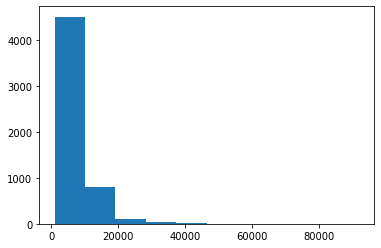

In [223]:
plt.hist(val_data[TARGET_NAME].values, bins=10)

(array([2.6676e+04, 5.9600e+02, 6.6000e+01, 1.6000e+01, 7.0000e+00,
        0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1004. ,  20903.6,  40803.2,  60702.8,  80602.4, 100502. ,
        120401.6, 140301.2, 160200.8, 180100.4, 200000. ]),
 <BarContainer object of 10 artists>)

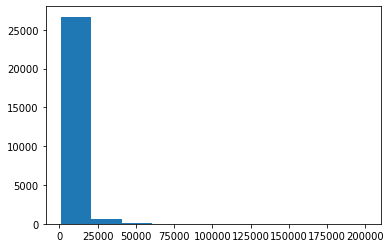

In [224]:
plt.hist(train_data[TARGET_NAME].values, bins=10)

In [330]:
val_pred = auto_ml.predict(val_data)

In [331]:
new_val_pred2 = val_pred.data*6652.25671478165/val_pred.data.mean()

In [332]:
new_val_pred = val_pred.data - val_pred.data.mean() + 6652.25671478165

In [333]:
val_data[TARGET_NAME].mean()

6652.256714781655

In [334]:
new_val_pred.mean()

6652.2563

In [335]:
new_val_pred2.mean()

6652.2573

In [336]:
mean_absolute_error(val_data[TARGET_NAME], val_pred.data)

1369.0000341475695

In [338]:
mean_absolute_error(val_data[TARGET_NAME], new_val_pred2)

1382.75950337345

In [339]:
mean_absolute_error(val_data[TARGET_NAME], new_val_pred)

1389.3212220609983

In [143]:
ls

[(2407.8258371229854,
  "{'use_algos': ['lgb', 'lgb_tuned', 'linear_l2', 'cb', 'cb_tuned']}",
  "[('mean', <function mean at 0x7f7d88043048>), ('min', <function nanmin at 0x7f7d780e5840>), ('max', <function nanmax at 0x7f7d780e59d8>), ('median', <function median at 0x7f7d780d5d90>)]"),
 (2352.0691284305367,
  "{'use_algos': [['lgb', 'lgb_tuned', 'linear_l2', 'cb', 'cb_tuned'], ['lgb', 'linear_l2']]}",
  "[('mean', <function mean at 0x7f7d88043048>), ('min', <function nanmin at 0x7f7d780e5840>), ('max', <function nanmax at 0x7f7d780e59d8>), ('median', <function median at 0x7f7d780d5d90>)]")]

In [124]:
ls

[(2301.5487437540464,
  "{'use_algos': ['linear_l2', 'lgb', 'lgb_tuned']}",
  "[('mean', <function mean at 0x7f7d88043048>), ('min', <function nanmin at 0x7f7d780e5840>), ('max', <function nanmax at 0x7f7d780e59d8>)]"),
 (2294.0690331959045,
  "{'use_algos': ['linear_l2', 'lgb', 'lgb_tuned']}",
  "[('mean', <function mean at 0x7f7d88043048>), ('min', <function nanmin at 0x7f7d780e5840>), ('max', <function nanmax at 0x7f7d780e59d8>), ('median', <function median at 0x7f7d780d5d90>)]"),
 (2368.170090152536,
  "{'use_algos': 'auto'}",
  "[('mean', <function mean at 0x7f7d88043048>), ('min', <function nanmin at 0x7f7d780e5840>), ('max', <function nanmax at 0x7f7d780e59d8>)]"),
 (2352.0691284305367,
  "{'use_algos': 'auto'}",
  "[('mean', <function mean at 0x7f7d88043048>), ('min', <function nanmin at 0x7f7d780e5840>), ('max', <function nanmax at 0x7f7d780e59d8>), ('median', <function median at 0x7f7d780d5d90>)]")]

In [56]:
# {'use_algos':'auto'}: 2816.1962
# {'use_algos': ['linear_l2', 'lgb', 'lgb_tuned']},:2813.14070621923

In [15]:
fast_fi = automl.get_feature_scores('fast')
# fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (20, 10), grid = True)

In [144]:
# fast_fi

In [147]:
automl.predict(val_data)

KeyError: "['FIXED_median_current_mileage_by_vehicle_category', 'FIXED_median_vehicle_year_by_vehicle_manufacturer', 'FIXED_median_current_mileage_by_deal_type', 'FIXED_median_vehicle_year_by_vehicle_model', 'FIXED_median_vehicle_year_by_deal_type', 'FIXED_median_car_leather_interior_by_vehicle_model', 'FIXED_median_vehicle_year_by_doors_cnt', 'FIXED_median_current_mileage_by_wheels', 'FIXED_median_car_leather_interior_by_vehicle_interior_color', 'FIXED_median_current_mileage_by_doors_cnt', 'FIXED_median_vehicle_year_by_vehicle_category', 'FIXED_median_vehicle_year_by_wheels', 'FIXED_median_current_mileage_by_vehicle_manufacturer', 'FIXED_median_current_mileage_by_vehicle_model', 'FIXED_median_vehicle_year_by_vehicle_color', 'FIXED_median_car_leather_interior_by_deal_type', 'FIXED_median_car_leather_interior_by_vehicle_color', 'FIXED_median_current_mileage_by_vehicle_color', 'FIXED_median_car_leather_interior_by_doors_cnt', 'FIXED_median_current_mileage_by_vehicle_gearbox_type', 'FIXED_median_car_leather_interior_by_vehicle_manufacturer', 'FIXED_median_car_leather_interior_by_vehicle_category', 'FIXED_median_vehicle_year_by_vehicle_gearbox_type', 'FIXED_median_car_leather_interior_by_vehicle_gearbox_type', 'FIXED_median_vehicle_year_by_vehicle_interior_color', 'FIXED_median_current_mileage_by_vehicle_interior_color', 'FIXED_median_car_leather_interior_by_wheels'] not in index"

In [354]:
test_pred2 = automl.predict(test_data)
logging.info('Prediction for test data:\n{}\nShape = {}'
              .format(test_pred2, test_pred2.shape))

logging.info('Check scores...')
logging.info('OOF score: {}'.format(mean_absolute_error(train_data[TARGET_NAME].values, oof_pred.data[:, 0])))

KeyError: "['FIXED_median_current_mileage_by_vehicle_category', 'FIXED_median_vehicle_year_by_vehicle_manufacturer', 'FIXED_median_current_mileage_by_deal_type', 'FIXED_median_vehicle_year_by_vehicle_model', 'FIXED_median_vehicle_year_by_deal_type', 'FIXED_median_car_leather_interior_by_vehicle_model', 'FIXED_median_vehicle_year_by_doors_cnt', 'FIXED_median_current_mileage_by_wheels', 'FIXED_median_car_leather_interior_by_vehicle_interior_color', 'FIXED_median_current_mileage_by_doors_cnt', 'FIXED_median_vehicle_year_by_vehicle_category', 'FIXED_median_vehicle_year_by_wheels', 'FIXED_median_current_mileage_by_vehicle_manufacturer', 'FIXED_median_current_mileage_by_vehicle_model', 'FIXED_median_vehicle_year_by_vehicle_color', 'FIXED_median_car_leather_interior_by_deal_type', 'FIXED_median_car_leather_interior_by_vehicle_color', 'FIXED_median_current_mileage_by_vehicle_color', 'FIXED_median_car_leather_interior_by_doors_cnt', 'FIXED_median_current_mileage_by_vehicle_gearbox_type', 'FIXED_median_car_leather_interior_by_vehicle_manufacturer', 'FIXED_median_car_leather_interior_by_vehicle_category', 'FIXED_median_vehicle_year_by_vehicle_gearbox_type', 'FIXED_median_car_leather_interior_by_vehicle_gearbox_type', 'FIXED_median_vehicle_year_by_vehicle_interior_color', 'FIXED_median_current_mileage_by_vehicle_interior_color', 'FIXED_median_car_leather_interior_by_wheels'] not in index"

In [17]:
test_pred

array([[ 2830.348 ],
       [ 5533.204 ],
       [ 2791.081 ],
       ...,
       [16834.004 ],
       [ 5083.2964],
       [ 6373.706 ]], dtype=float32)

In [362]:
# test_pred.data[:,0]

In [390]:
tm = test_pred.data[:,0].mean()

In [394]:
new_tt = test_pred.data*5454.77075/tm

In [404]:
new_tt[:,0]

array([ 2978.3877,  5903.131 ,  3481.8857, ..., 19628.518 ,  5418.863 ,
        6909.247 ], dtype=float32)

In [401]:
test_pred.data[:, 0]

array([ 2822.7456,  5594.65  ,  3299.9324, ..., 18602.787 ,  5135.6885,
        6548.1895], dtype=float32)

In [24]:
submission = pd.read_csv('sample_submission.csv')

In [25]:
submission[TARGET_NAME] = test_pred.data[:, 0]
submission.head()

,row_ID,final_price
0,35000,2843.389160
1,35001,5495.755371
2,35002,2903.427979
3,35003,6769.987793
4,35004,4283.917969


array([ 2978.3877,  5903.131 ,  3481.886 , ..., 19628.518 ,  5418.8633,
        6909.2476], dtype=float32)

In [26]:
submission.to_csv('submissions/submission_10_3600.csv', index = False)

In [ ]:
submission['final_price'] = 0

In [ ]:
submission.to_csv('submissions/submission_all_zeros.csv', index = False)

In [ ]:
submission4 = pd.read_csv('submissions/submission_4.csv')
np.mean(submission4['final_price'])

In [ ]:
submission4['final_price'] = submission4['final_price'] - np.mean(submission4['final_price']) + 5454.77075

In [ ]:
submission4.to_csv('submissions/submission_4_mae_hack.csv', index = False)

In [ ]:
# all zeros gives 5454.77075